# Imports and Data

In [7]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('filtered.pkl', 'rb') as handle:
    filtered = pickle.load(handle)
handle.close()

with open('filterednc.pkl', 'rb') as handle:
    filterednc = pickle.load(handle)
handle.close()

import statsmodels.api as sm

globalt0 = dt.datetime.now()

# Supplemental Information

This section recreates all plots for the SI with the data exports to create the plots in TiKz

## Different values of $T$

In [8]:
unfiltered.keys()

dict_keys(['mit', 'uk1', 'uk2', 'uk', 'all'])

In [9]:
t0 = dt.datetime.now()

callT = {}
for c in ['uk', 'uk2', 'mit']:
    df = unfiltered[c]
    callT[c] = {}
    for T in [150, 200, 250, 300]:
        callT[c][T] = df.loc[df['aclock'] <= T]
        uno = pd.DataFrame()
        maxt = max(callT[c][T]['uclock'])
        for ego in callT[c][T]['ego'].unique():
            df1 = callT[c][T].loc[callT[c][T]['ego'] == ego]
            for alter in df1['alter'].unique():
                df2 = df1.loc[df1['alter'] == alter]
                mint = min(df2['uclock'])
                if mint < (maxt - T):
                    df3 = df2.copy()
                    df3['aclock'] = df2['uclock'] - mint
                    uno = uno.append(df3).reset_index(drop=True)
        callT[c][T] = uno
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:28.865392


In [10]:
supA = {}
for c in callT.keys():
    supA[c] = {}
    for T in callT[c].keys():
        dff = pc.get_f(callT[c][T], 'all', 15, (T//3) + 1)
        b = pc.get_b(dff, 'alpha')
        supA[c][T] = pc.plot_g(b, 'alpha')

In [11]:
with open('../itdata/mtl_supA.pickle', 'rb') as handle:
    tmp = pickle.load(handle)
    handle.close()
    
supA['it'] = {}    
for T in tmp.keys():
    b = pc.get_b(tmp[T], 'alpha')
    supA['it'][T] = pc.plot_g(b, 'alpha')

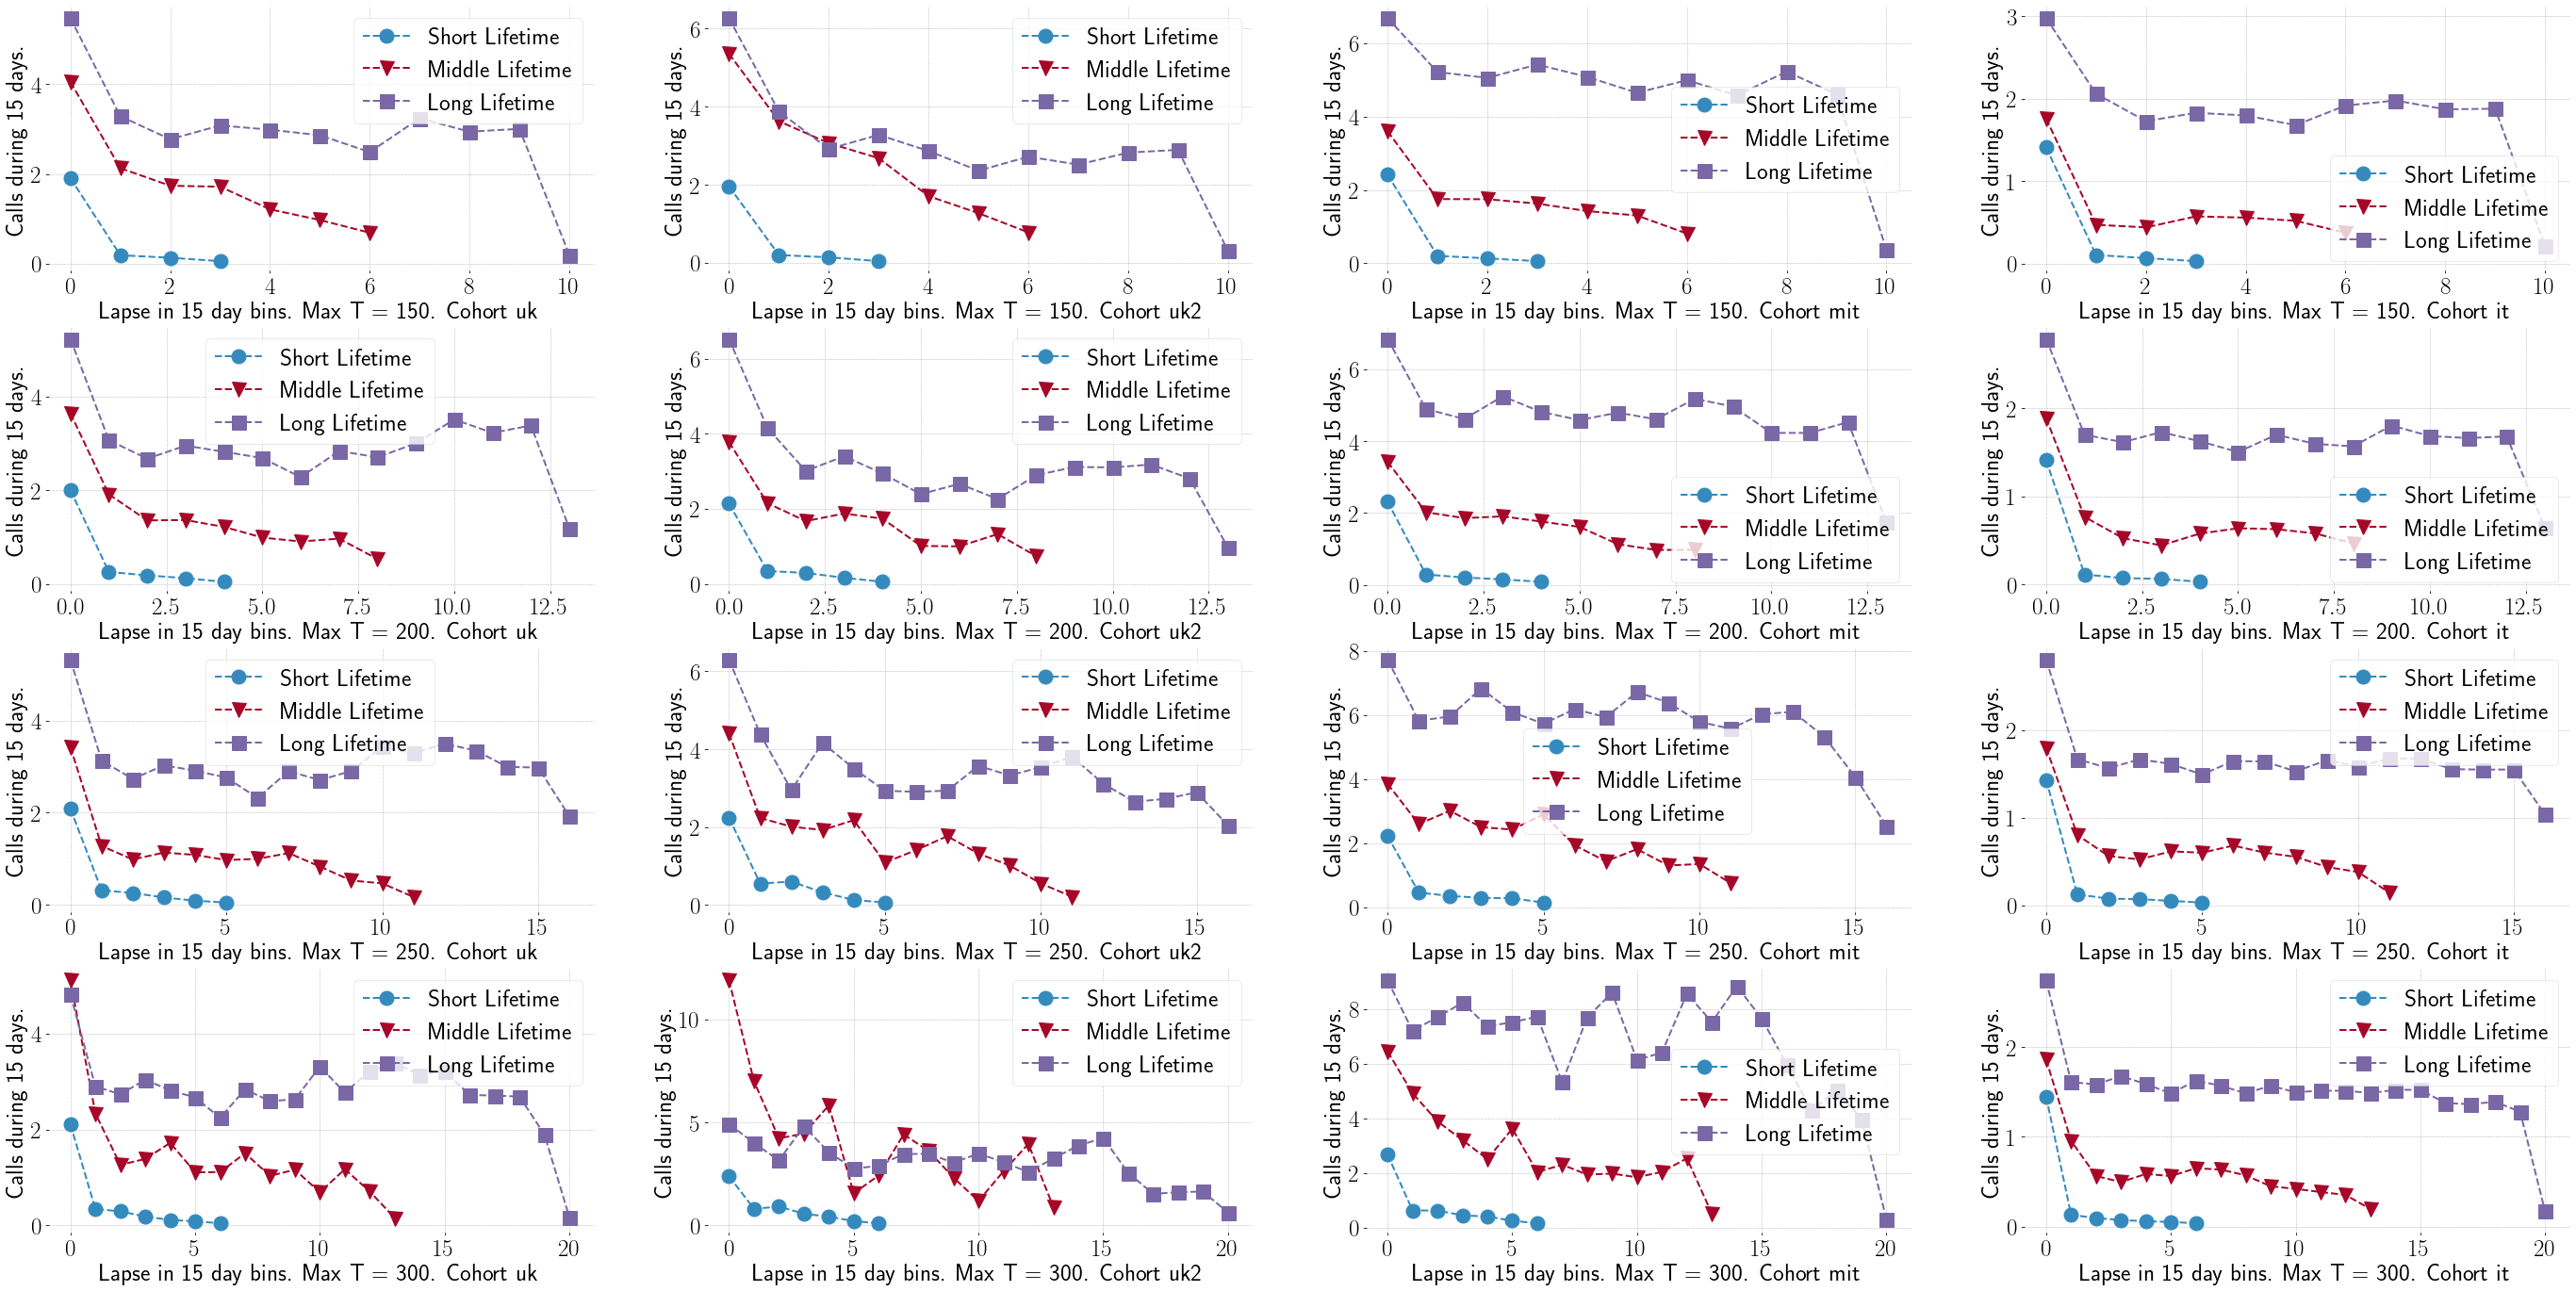

In [12]:
plt.figure(figsize=(48, 24))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
p = 1
for T in supA['uk'].keys():
    for c in supA.keys():
        plt.subplot(4,4,p)
        plt.xlabel(f"Lapse in 15 day bins. Max T = {T}. Cohort {c}")
        plt.ylabel(fr"Calls during 15 days.")
        for l in supA[c][T].keys():
            plt.plot(supA[c][T][int(l)].index, supA[c][T][l]['alpha'], marker=markers[int(l)], markersize=15, ls="--", label=labels[int(l)])
        plt.legend()
        p += 1

In [13]:
lines = {}
lines[150] = {}
for lamb in range(3):
    lines[150][lamb] = (1, (lamb + 1)*3)
lines[200] = {}
for lamb in range(3):
    lines[200][lamb] = (1, [4,8,11][lamb])
lines[250] = {}
for lamb in range(3):
    lines[250][lamb] = (1, [5, 10, 14][lamb])
lines[300] = {}
for lamb in range(3):
    lines[300][lamb] = (1, [6, 13, 18][lamb])

In [14]:
for c in supA.keys():
    print(f'======================={c}=====================')
    for T in supA[c].keys():
        print(f'===={T}====')
        for lamb in supA[c][T].keys():
            df = supA[c][T][lamb].loc[(supA[c][T][lamb].index >= lines[T][lamb][0]) & (supA[c][T][lamb].index <= lines[T][lamb][1])]
            h = np.mean(df['alpha'])
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(lamb)]}, ultra thick] (axis cs: {lines[T][lamb][0]}, {h}) -- (axis cs: {lines[T][lamb][1]}, {h});')

=======================uk=====================
====150====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.12572738617949086) -- (axis cs: 3, 0.12572738617949086);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.4082226577147574) -- (axis cs: 6, 1.4082226577147574);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.9602677167464977) -- (axis cs: 9, 2.9602677167464977);
====200====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.15375061155871803) -- (axis cs: 4, 0.15375061155871803);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.157395372544182) -- (axis cs: 8, 1.157395372544182);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.8883785592862505) -- (axis cs: 11, 2.8883785592862505);
====250====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.1726138053828296) -- (axis cs: 5, 0.1726138053828296);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.9385989112127667) -- (axis cs: 10, 0.9385989112127667);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.99606161

In [15]:
# for c in supA.keys():
#     tmp = pd.DataFrame(index=list(range(21)))
#     for T in supA[c].keys():
#         for lamb in supA[c][T].keys():
#             df = supA[c][T][lamb]
#             if lamb == 2:
#                 df = df.loc[df.index < list(df.index)[-1]] # To crop the last part of the longer lifetime series
#             df.columns = [f'T{T}l{int(lamb)}']
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#         tmp.index.rename('a', inplace=True)
#         tmp.fillna('nan', inplace=True)
#         tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIa_{c}.dat", header=True, sep="\t")

## Changes in $\Delta a$ for fig 2

In [16]:
calls = {}
for c in callT.keys():
    calls[c] = callT[c][200]

In [17]:
supB = {}
for c in calls.keys():
    supB[c] = {}
    for Da in [7, 15, 30, 45]:
        dff = pc.get_f(calls[c], 'all', Da, 67)
        b = pc.get_b(dff, 'alpha')
        supB[c][Da] = pc.plot_g(b, 'alpha')

In [18]:
with open('../itdata/mtl_supB.pickle', 'rb') as handle:
    tmp = pickle.load(handle)
    handle.close()
    
supB['it'] = {}    
for Da in tmp.keys():
    b = pc.get_b(tmp[Da], 'alpha')
    supB['it'][Da] = pc.plot_g(b, 'alpha')

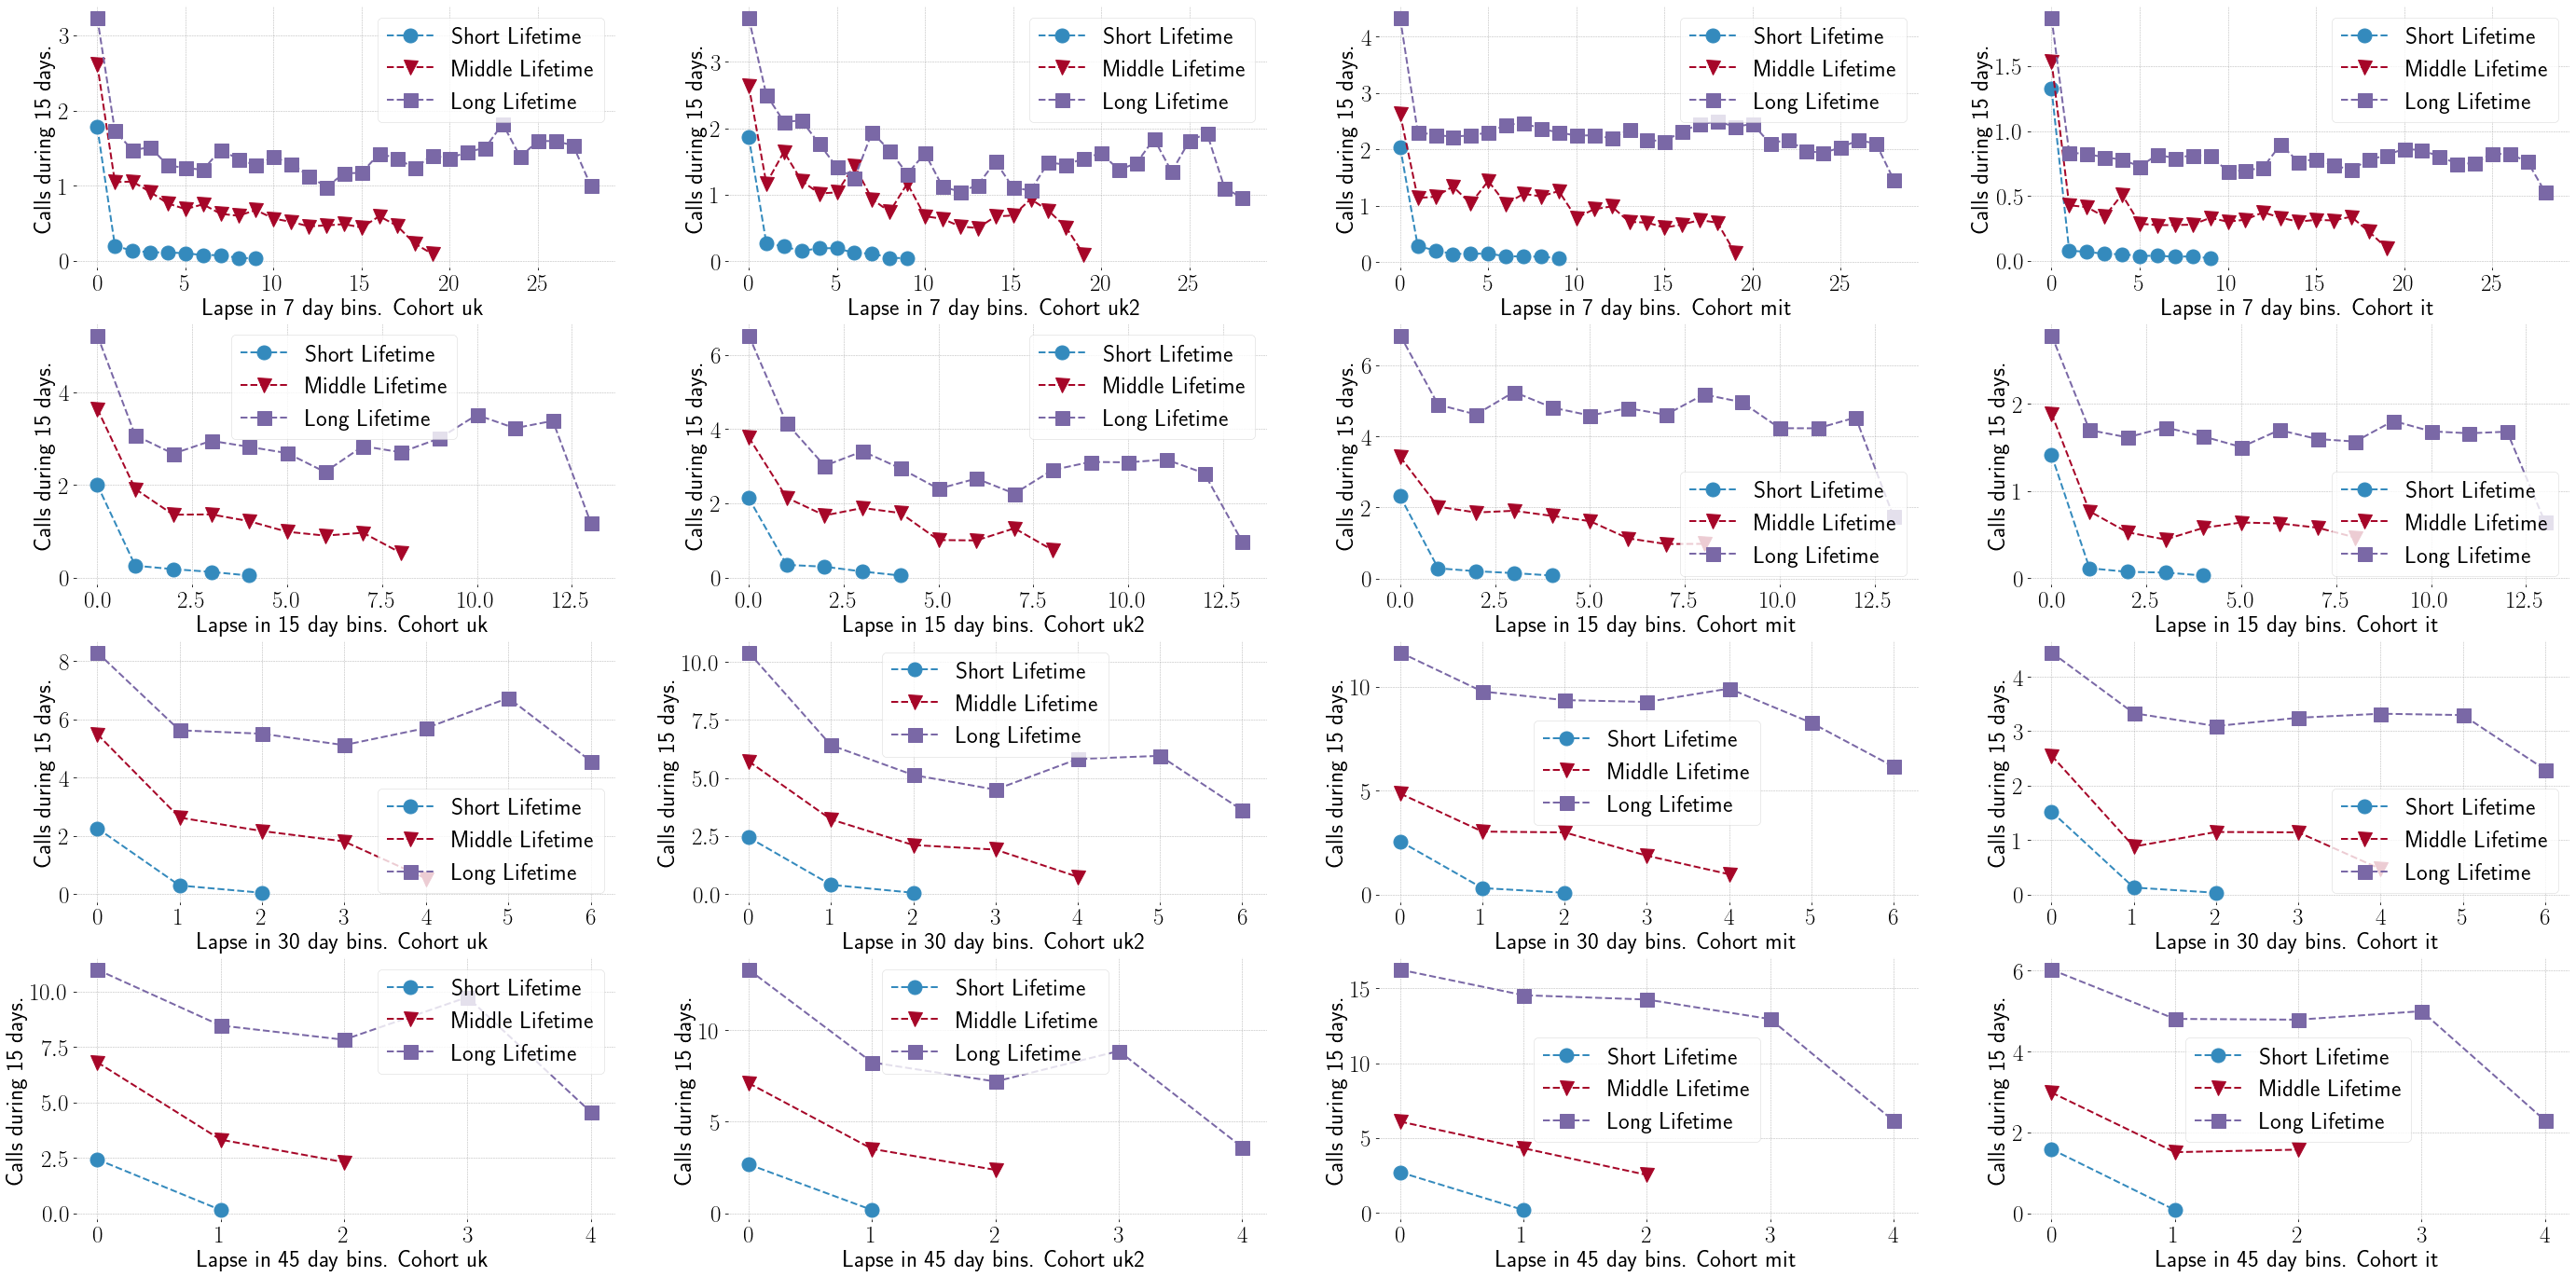

In [19]:
plt.figure(figsize=(48, 24))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
p = 1
for Da in supB['uk'].keys():
    for c in supB.keys():
        plt.subplot(4,4,p)
        plt.xlabel(f"Lapse in {Da} day bins. Cohort {c}")
        plt.ylabel(fr"Calls during 15 days.")
        for l in supB[c][Da].keys():
            plt.plot(supB[c][Da][int(l)].index, supB[c][Da][l]['alpha'], marker=markers[int(l)], markersize=15, ls="--", label=labels[int(l)])
        plt.legend()
        p += 1

In [20]:
supB['uk'].keys()

dict_keys([7, 15, 30, 45])

In [21]:
lines = {}
lines[7] = {}
for lamb in range(3):
    lines[7][lamb] = (1, [9, 15, 27][lamb])
lines[15] = {}
for lamb in range(3):
    lines[15][lamb] = (1, [4,8,12][lamb])
lines[30] = {}
for lamb in range(3):
    lines[30][lamb] = (1, [2,3,5][lamb])
lines[45] = {}
for lamb in range(3):
    lines[45][lamb] = (1, [1,2,3][lamb])

In [22]:
for c in supB.keys():
    print(f'======================={c}=====================')
    for Da in supB[c].keys():
        print(f'===={Da}====')
        for lamb in supB[c][Da].keys():
            df = supB[c][Da][lamb].loc[(supB[c][Da][lamb].index >= lines[Da][lamb][0]) & (supB[c][Da][lamb].index <= lines[Da][lamb][1])]
            h = np.mean(df['alpha'])
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(lamb)]}, ultra thick] (axis cs: {lines[Da][lamb][0]}, {h}) -- (axis cs: {lines[Da][lamb][1]}, {h});')

=======================uk=====================
====7====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.1006856972225063) -- (axis cs: 9, 0.1006856972225063);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.6724577679283055) -- (axis cs: 15, 0.6724577679283055);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 1.3829309240199206) -- (axis cs: 27, 1.3829309240199206);
====15====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.15375061155871803) -- (axis cs: 4, 0.15375061155871803);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.157395372544182) -- (axis cs: 8, 1.157395372544182);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.929652680811337) -- (axis cs: 12, 2.929652680811337);
====30====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.17184927905216932) -- (axis cs: 2, 0.17184927905216932);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 2.203400323280638) -- (axis cs: 3, 2.203400323280638);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 5.74031359550599)

In [23]:
# for c in supB.keys():
#     tmp = pd.DataFrame(index=list(range(29)))
#     for Da in supB[c].keys():
#         for lamb in supB[c][Da].keys():
#             df = supB[c][Da][lamb]
#             if (lamb == 2) and (Da < 30):
#                 df = df.loc[df.index < list(df.index)[-1]] # To crop the last part of the longer lifetime series
#             df.columns = [f'Da{Da}l{int(lamb)}']
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#         tmp.index.rename('a', inplace=True)
#         tmp.fillna('nan', inplace=True)
#         tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIb_{c}.dat", header=True, sep="\t")

## Changes in $\Delta \ell$

The idea here is that, instead of producing three groups, I could get less or more for the plots in fig 2

In [24]:
calls = {}
for c in callT.keys():
    calls[c] = callT[c][200]
    
supC = {}
for c in calls.keys():
    supC[c] = {}
    for series in [2,3,4,5]:
        gs = (200 // series) + 1
        dff = pc.get_f(calls[c], 'all', 15, gs)
        b = pc.get_b(dff, 'alpha')
        supC[c][gs] = pc.plot_g(b, 'alpha')

In [127]:
lives.keys()

dict_keys(['uk2', 'uk', 'mit', 'it', 'all'])

In [128]:
with open('../itdata/mtl_supA.pickle', 'rb') as handle:
    tmp = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_all_lives.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
lives['it'] = itlives['all']
    
supC['it'] = {}

for series in [2,3,4,5]:
    gs = (200 // series) + 1
    dff = copy.deepcopy(tmp[200])
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter]
            df['lambda'] = itlives['all'][ego][alter]['ell'] // gs
    b = pc.get_b(dff, 'alpha')
    supC['it'][gs] = pc.plot_g(b, 'alpha')

In [102]:
supC['mit'][51][2]

alpha
0.0   3.645056
1.0   2.562721
2.0   2.735804
3.0   2.540052
4.0   2.341571
5.0   2.093988
6.0   1.975661
7.0   1.878749
8.0   1.585288
9.0   1.082778
10.0  0.355241

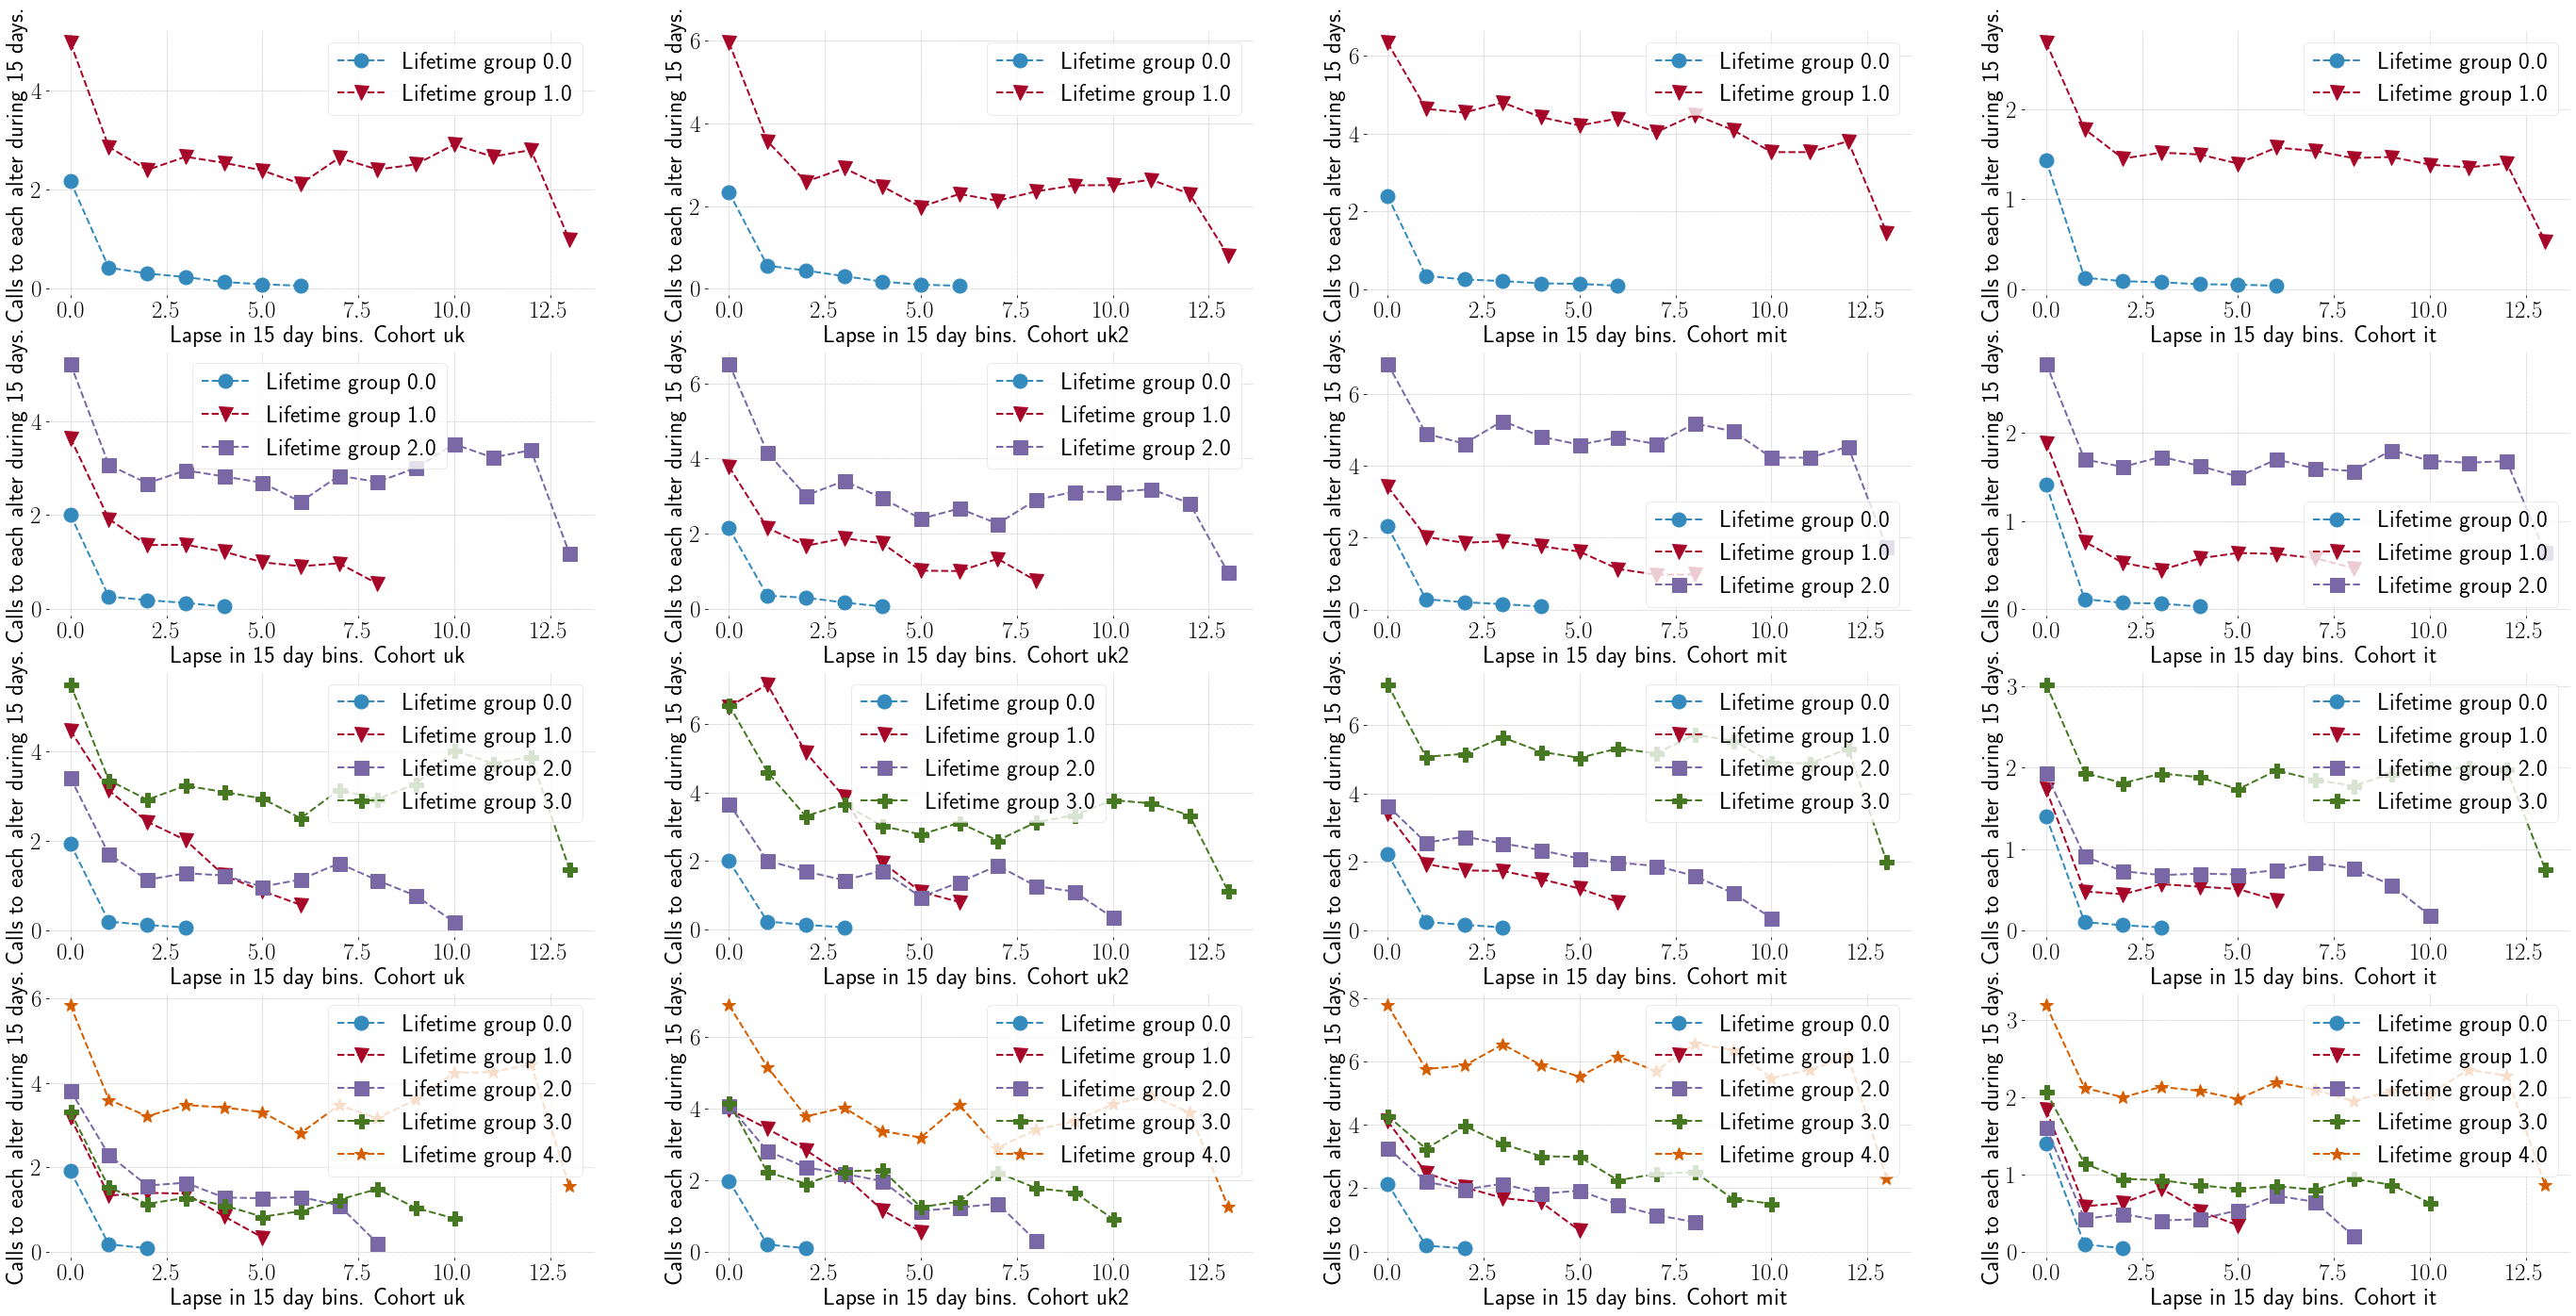

In [28]:
plt.figure(figsize=(48, 24))
p = 1
for gs in supC['uk'].keys():
    for c in supC.keys():
        plt.subplot(4,4,p)
        plt.xlabel(f"Lapse in 15 day bins. Cohort {c}")
        plt.ylabel(fr"Calls to each alter during 15 days.")
        for l in supC[c][gs].keys():
            plt.plot(supC[c][gs][int(l)].index, supC[c][gs][l]['alpha'], marker=markers[int(l)], markersize=15, ls="--", label=f'Lifetime group {l}')
        plt.legend()
        p += 1

In [29]:
supC['it'][41].keys()

dict_keys([0.0, 1.0, 2.0, 3.0, 4.0])

In [30]:
lines = {}
for Dl in supC['uk'].keys():
    lines[Dl] = {}
    for lamb in supC['uk'][Dl].keys():
        lines[Dl][lamb] = (1, list(supC['uk'][Dl][lamb].index)[-1])
lines

{101: {0.0: (1, 6.0), 1.0: (1, 13.0)},
 67: {0.0: (1, 4.0), 1.0: (1, 8.0), 2.0: (1, 13.0)},
 51: {0.0: (1, 3.0), 1.0: (1, 6.0), 2.0: (1, 10.0), 3.0: (1, 13.0)},
 41: {0.0: (1, 2.0),
  1.0: (1, 5.0),
  2.0: (1, 8.0),
  3.0: (1, 10.0),
  4.0: (1, 13.0)}}

In [31]:
for c in supC.keys():
    print(f'======================={c}=====================')
    for Dl in supC[c].keys():
        print(f'===={Dl}====')
        for lamb in supC[c][Dl].keys():
            df = supC[c][Dl][lamb].loc[(supC[c][Dl][lamb].index >= lines[Dl][lamb][0]) & (supC[c][Dl][lamb].index <= lines[Dl][lamb][1])]
            h = np.mean(df['alpha'])
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans", "snorlax", "raichu"][int(lamb)]}, ultra thick] (axis cs: {lines[Dl][lamb][0]}, {h}) -- (axis cs: {lines[Dl][lamb][1]}, {h});')

=======================uk=====================
====101====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.1992447984333331) -- (axis cs: 6.0, 0.1992447984333331);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 2.450308515714291) -- (axis cs: 13.0, 2.450308515714291);
====67====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.15375061155871803) -- (axis cs: 4.0, 0.15375061155871803);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.157395372544182) -- (axis cs: 8.0, 1.157395372544182);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 2.7953040661882795) -- (axis cs: 13.0, 2.7953040661882795);
====51====
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.12055472740323177) -- (axis cs: 3.0, 0.12055472740323177);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.7032716863713888) -- (axis cs: 6.0, 1.7032716863713888);
\draw[dashed, ekans, ultra thick] (axis cs: 1, 1.0965031490134858) -- (axis cs: 10.0, 1.0965031490134858);
\draw[dashed, snorlax, ultra thick] (axis cs

In [32]:
supC['uk'][41].keys()

dict_keys([0.0, 1.0, 2.0, 3.0, 4.0])

In [33]:
# for c in supC.keys():
#     tmp = pd.DataFrame(index=list(range(14)))
#     for Dl in supC[c].keys():
#         for lamb in supC[c][Dl].keys():
#             df = supC[c][Dl][lamb]
#             if (lamb == max(supC[c][Dl].keys())):
#                 df = df.loc[df.index < list(df.index)[-1]] # To crop the last part of the longer lifetime series
#             df.columns = [f'Dl{Dl}l{int(lamb)}']
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#         tmp.index.rename('a', inplace=True)
#         tmp.fillna('nan', inplace=True)
#         tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIc_{c}.dat", header=True, sep="\t")

## Distribution of number of calls

In [34]:
supD = {}
for c in callT.keys():
    supD[c] = {}
    df = callT[c][200]
    pp = pc.pairs(df)
    hist = pc.histogram(list(pp['nij']), 30)
    supD[c]['all'] = hist
    df1 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    pp = pc.pairs(df1)
    hist = pc.histogram(list(pp['nij']), 30)
    supD[c]['sub'] = hist

In [35]:
with open('../itdata/mtl_supC.pickle', 'rb') as handle:
    supD['it'] = pickle.load(handle)
    handle.close()

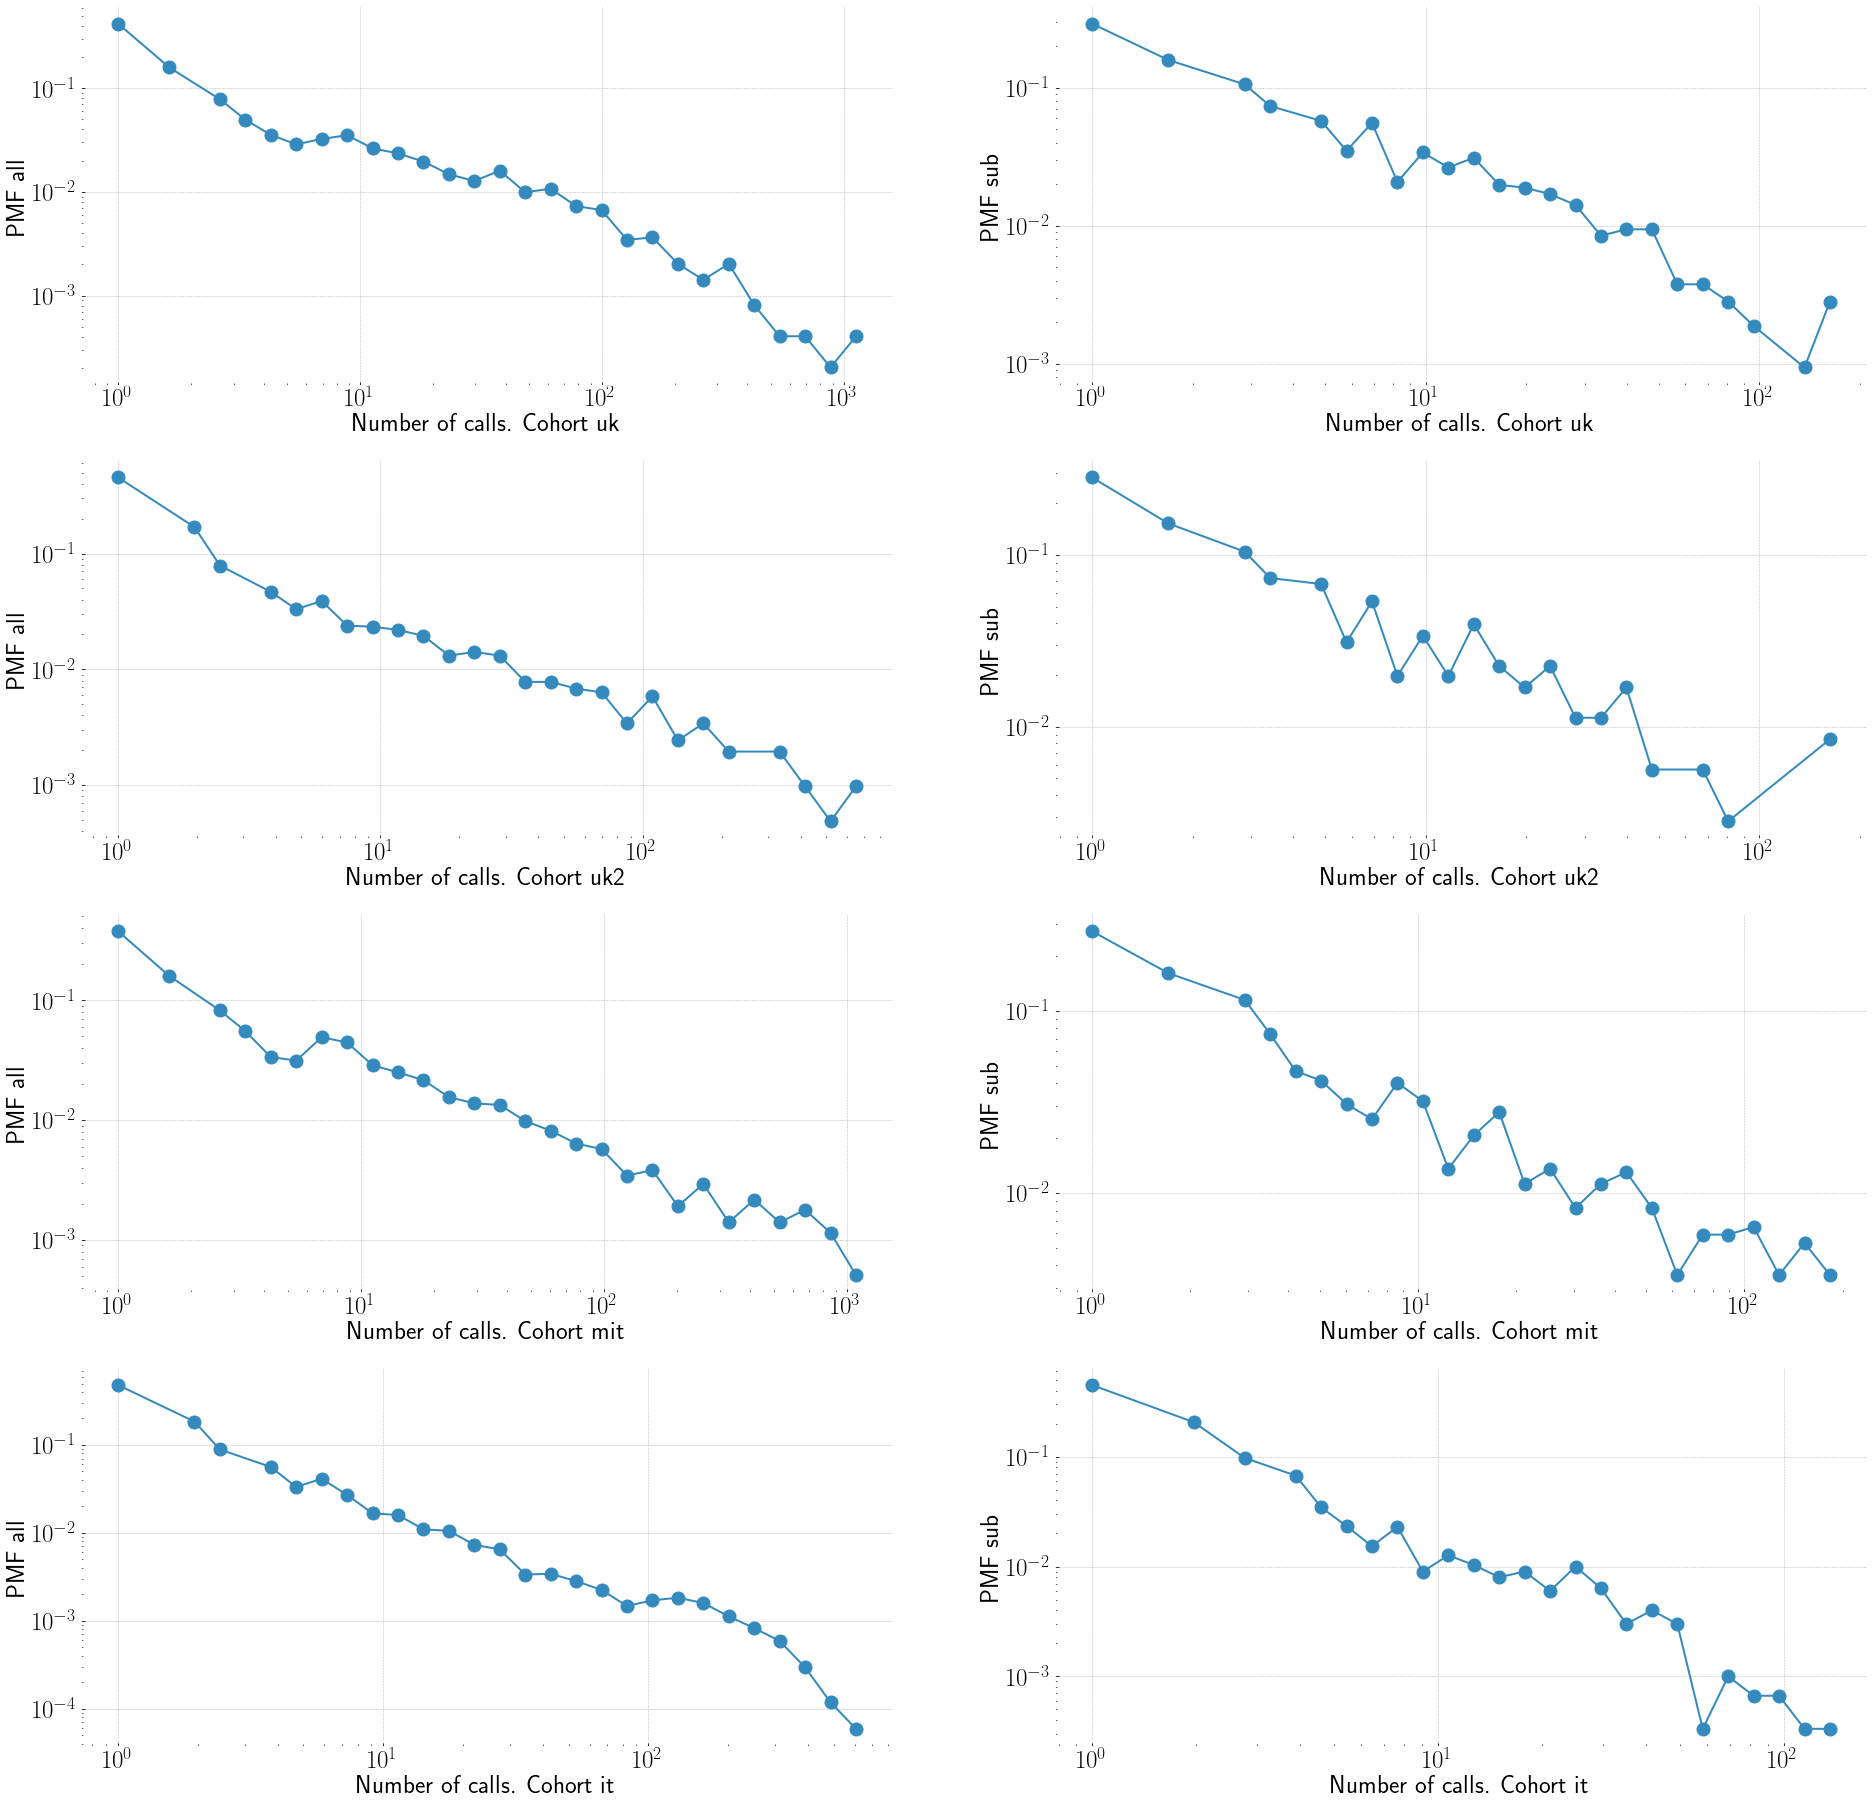

In [36]:
plt.figure(figsize=(32, 32))
p = 1
for c in supD.keys():
    for sample in supD[c].keys():
        plt.subplot(4,2,p)
        plt.xlabel(f"Number of calls. Cohort {c}")
        plt.ylabel(f"PMF {sample}")
        plt.loglog()
        df = supD[c][sample]
        plt.plot(df['label'], df['pmf'], "o-", markersize=13)
        p += 1

In [37]:
for row in supD.keys():
    for col in supD[row].keys():
        df = supD[row][col]
        if len(df) != 30:
            print(row, col, len(df))

uk all 28
uk sub 24
uk2 all 26
uk2 sub 21
mit all 28
mit sub 26
it all 27
it sub 25


In [40]:
tmp = pd.DataFrame(index=list(range(30)))
for c in supD.keys():
    for col in supD[c].keys():
        df = supD[c][col].sort_index()
        x = []
        y = []
        df2 = df.reset_index(drop=True)
        for i in range(30):
            if i in df2.index:
                x.append(df2.at[i, 'label'])
                y.append(df2.at[i, 'pmf'])
            else:
                x.append('nan')
                y.append('nan')
        tmp[f'{c+col}_x'] = x
        tmp[f'{c+col}_y'] = y
tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SId.dat", header=True, index=False, sep="\t")

## Variants of the contour plot

The first variant uses Italy and UK for the contours and plots it with points from USA

In [41]:
alldff2 = {}
for c in calls.keys():
    alldff2[c] = pc.get_f(calls[c], 'all', 30, 10)
    
with open('../itdata/mtl_all_lambda_alpha_fig3.pickle', 'rb') as handle:
    alldff2['it'] = pickle.load(handle)
    handle.close()
    
dffUI = {}
for c in ['uk', 'it']:
    dffUI.update(alldff2[c])

surv_cont = pc.get_survival(dffUI)

tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/supEac.dat", header=False, index=False, sep="\t")

points_usa = pc.get_survival(alldff2['mit'], unbinned=True)

tmp = pd.DataFrame()
for s in points_usa.keys():
    if s <= 2**5 + 1:
        df = points_usa[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
for s in sub:
    df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
    df2 = df.drop(columns='z')
    df2.to_csv(f'../commpatterns/PNAS_paper/SI/figs/supEap{p}.dat', header=False, index=False, sep="\t")
    print(s)
    p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


And now using points from the UK dataset

In [42]:
dffMI = {}
for c in ['mit', 'it']:
    dffMI.update(alldff2[c])

surv_cont = pc.get_survival(dffMI)

tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/supEbc.dat", header=False, index=False, sep="\t")

points_uk = pc.get_survival(alldff2['uk'], unbinned=True)

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 2**5 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
for s in sub:
    df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
    df2 = df.drop(columns='z')
    df2.to_csv(f'../commpatterns/PNAS_paper/SI/figs/supEbp{p}.dat', header=False, index=False, sep="\t")
    print(s)
    p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# Individual results for each cohort

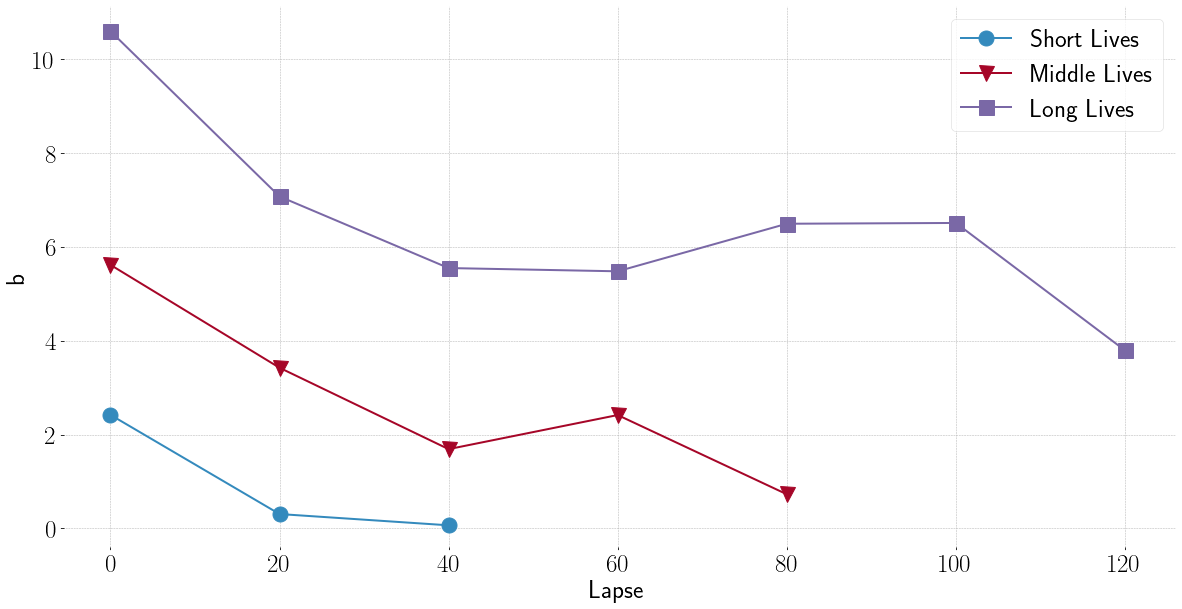

In [43]:
labels = ['Short Lives', 'Middle Lives', 'Long Lives']
uk2calls = filtered['uk2']
uk2dff = pc.get_f(uk2calls, 'all', 30, 67)
b = pc.get_b(uk2dff, 'alpha')
uk2stable = pc.plot_g(b, 'alpha')

plt.xlabel("Lapse")
plt.ylabel("b")
for lamb in uk2stable.keys():
    l = int(lamb)
    plt.plot([20 * x for x in uk2stable[l].index], uk2stable[l]['alpha'], marker=markers[l], markersize=15, label=labels[l])
plt.legend()

In [44]:
calls = {}
for c in ['uk2', 'uk', 'mit']:    
    df = unfiltered[c].loc[unfiltered[c]['aclock'] <= 200]
#     if c != 'uk2':
#         une = df.groupby('ego')[['uclock']].min()
#         deux = pd.DataFrame()
#         for ego in df['ego'].unique():
#             tmp = df.loc[df['ego'] == ego]
#             minday = une.loc[ego]['uclock'] + 10
#             df1 = df.loc[df['uclock'] >= minday]
#             deux = deux.append(df1).reset_index(drop=True)
#         df = deux
    uno = pd.DataFrame()
    T = max(df['uclock'])
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df3 = df2.copy()
                df3['aclock'] = df2['uclock'] - mint
                uno = uno.append(df3).reset_index(drop=True)
    calls[c] = uno
    print(f"done with {c}")

done with uk2
done with uk
done with mit


In [45]:
alldff = {}
for c in calls.keys():
    alldff[c] = pc.get_f(calls[c], 'all', 15, 67)
    
with open('../itdata/mtl_all_lambda_alpha_fig2.pickle', 'rb') as handle:
    alldff['it'] = pickle.load(handle)
    handle.close()

In [46]:
alldff['it'][37]['c308ad2e46e9cb3c3f1af8737085d1e6']

lambda  alpha  f
0       1      0  1
1       1      4  2
2       1      7  1

In [47]:
stablec = {}
for c in alldff.keys():
    b = pc.get_b(alldff[c], 'alpha')
    stablec[c] = pc.plot_g(b, 'alpha')

In [48]:
stablec['it'].keys()

dict_keys([0.0, 1.0, 2.0])

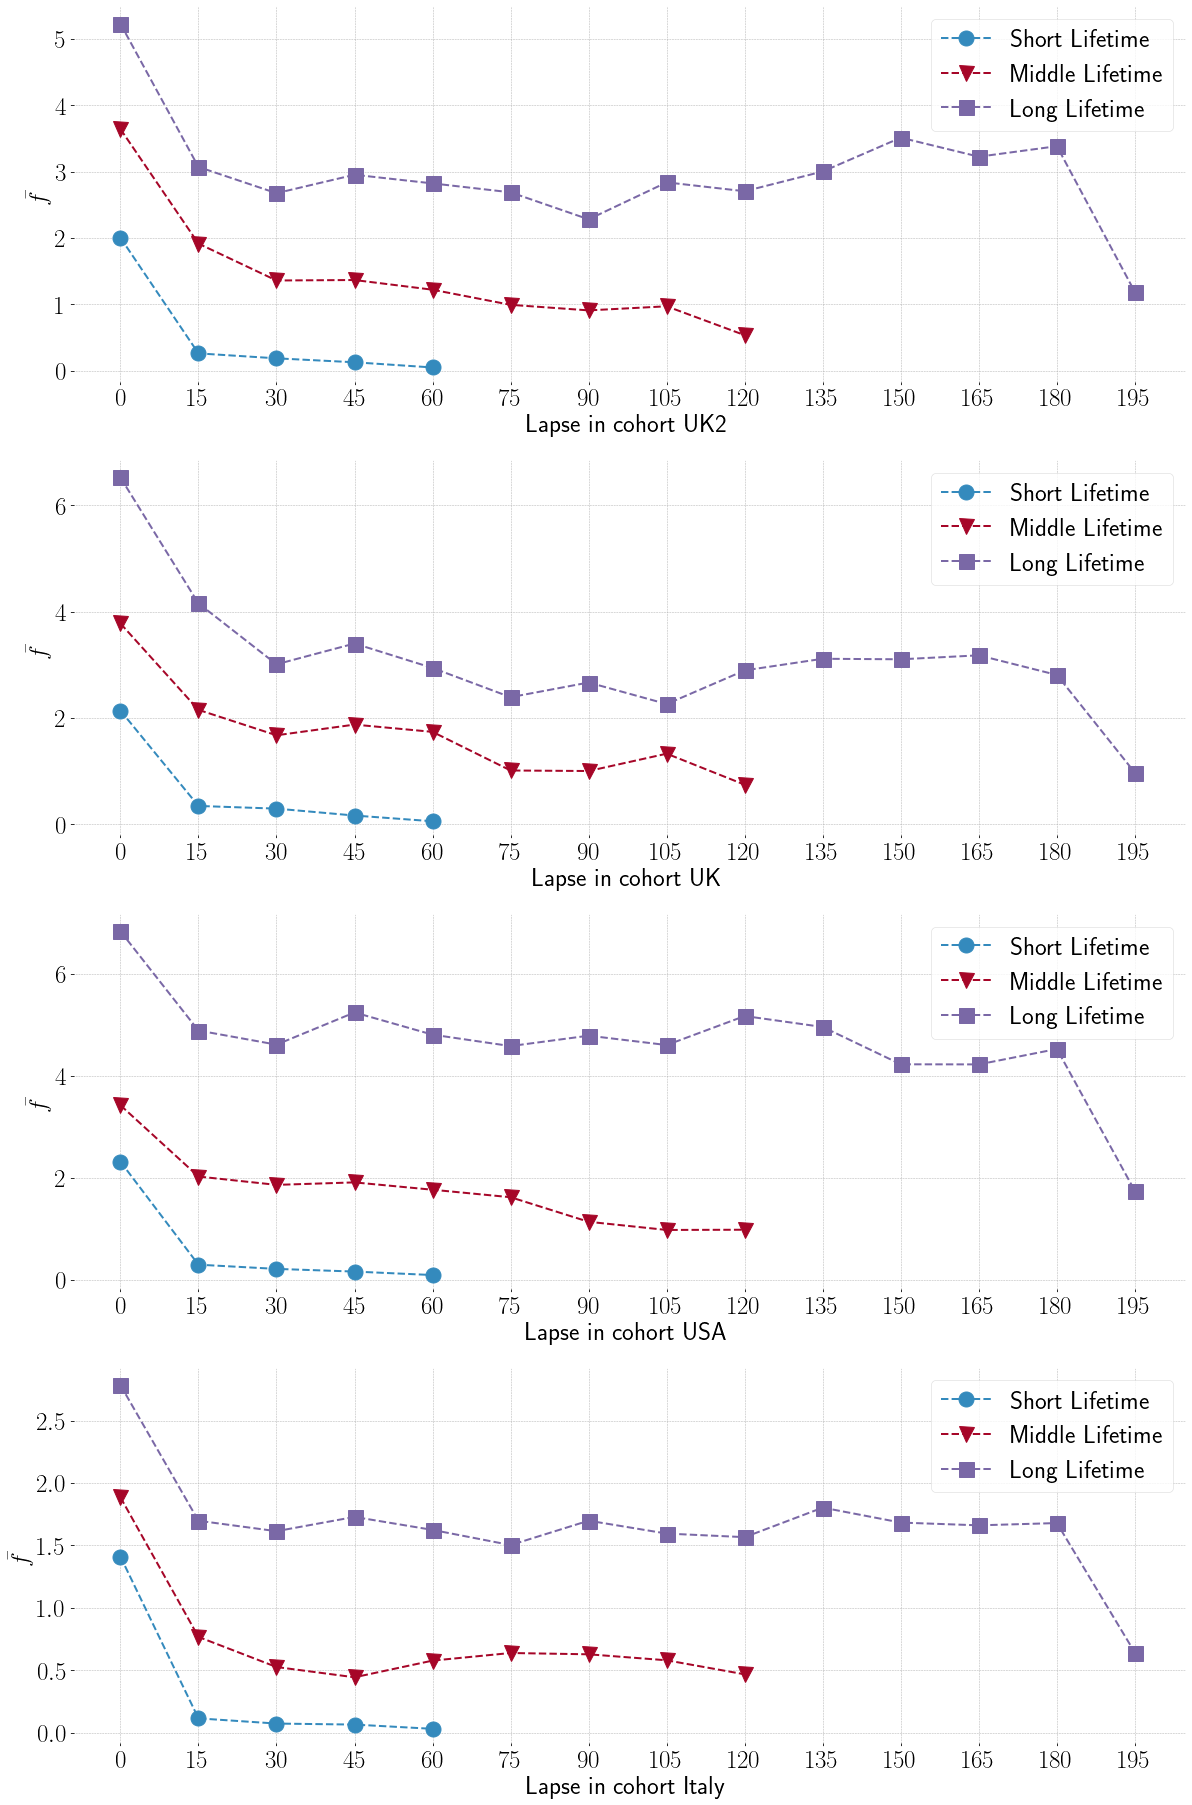

In [49]:
plt.figure(figsize=(20, 32))
p = 1
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
cohorts = ['UK2', 'UK', 'USA', 'Italy']
for c in ['uk', 'uk2', 'mit', 'it']:
    plt.subplot(4,1,p)
    plt.xlabel(f"Lapse in cohort {cohorts[p - 1]}")
    plt.ylabel(r"$\bar{f}$")
    plt.xticks(range(0, 201, 15))
    for lamb in stablec[c].keys():
        l = int(lamb)
        plt.plot([15 * x for x in stablec[c][l].index], stablec[c][l]['alpha'], marker=markers[l], ls="--", markersize=15, label=labels[l])
    plt.legend()
    p += 1
#     if p > 3:
#         break 
#plt.savefig("../commpatterns/img/supp/stablec.pdf", dpi=150)

In [50]:
df0 = stablec['uk2'][0].loc[(stablec['uk2'][0].index >= 1) & (stablec['uk2'][0].index <= 4)]
print(np.mean(df0['alpha']))
df1 = stablec['uk2'][1].loc[(stablec['uk2'][1].index >= 1) & (stablec['uk2'][1].index <= 7)]
print(np.mean(df1['alpha']))
df2 = stablec['uk2'][2].loc[(stablec['uk2'][2].index >= 2) & (stablec['uk2'][2].index <= 12)]
print(np.mean(df2['alpha']))

0.213116418847782
1.5391900748474954
2.888082467790635


In [51]:
df0 = stablec['uk'][0].loc[(stablec['uk'][0].index >= 1) & (stablec['uk'][0].index <= 4)]
print(np.mean(df0['alpha']))
df1 = stablec['uk'][1].loc[(stablec['uk'][1].index >= 2) & (stablec['uk'][1].index <= 7)]
print(np.mean(df1['alpha']))
df2 = stablec['uk'][2].loc[(stablec['uk'][2].index >= 1) & (stablec['uk'][2].index <= 9)]
print(np.mean(df2['alpha']))

0.15375061155871803
1.1351696356670564
2.781631105313679


In [52]:
df0 = stablec['mit'][0].loc[(stablec['mit'][0].index >= 1) & (stablec['mit'][0].index <= 4)]
print(np.mean(df0['alpha']))
df1 = stablec['mit'][1].loc[(stablec['mit'][1].index >= 2) & (stablec['mit'][1].index <= 5)]
print(np.mean(df1['alpha']))
df2 = stablec['mit'][2].loc[(stablec['mit'][2].index >= 1) & (stablec['mit'][2].index <= 12)]
print(np.mean(df2['alpha']))

0.18795707197388795
1.7877656238804818
4.7208945618078575


In [53]:
df0 = stablec['it'][0].loc[(stablec['it'][0].index >= 1) & (stablec['it'][0].index <= 4)]
print(np.mean(df0['alpha']))
df1 = stablec['it'][1].loc[(stablec['it'][1].index >= 1) & (stablec['it'][1].index <= 8)]
print(np.mean(df1['alpha']))
df2 = stablec['it'][2].loc[(stablec['it'][2].index >= 2) & (stablec['it'][2].index <= 12)]
print(np.mean(df2['alpha']))

0.07021230071677531
0.5781245964582644
1.6508506062162496


In [54]:
for c in stablec.keys():
    for l in stablec[c].keys():
        print(l, pc.get_plateau(stablec[c][l], 0.8))
    print("=======================================")

0.0 (1.0, 3.0, 0.2659024316082226)
1.0 (3.0, 5.0, 1.5407124546329092)
2.0 (6.0, 8.0, 2.6076730710984997)
0.0 (1.0, 3.0, 0.18945199233796364)
1.0 (2.0, 6.0, 1.168381331588642)
2.0 (5.0, 9.0, 2.702759399525557)
0.0 (1.0, 3.0, 0.22064980821749225)
1.0 (2.0, 6.0, 1.6572320184739049)
2.0 (5.0, 9.0, 4.822675024923522)
0.0 (1.0, 3.0, 0.0835611522869134)
1.0 (1.0, 7.0, 0.5940147228506205)
2.0 (2.0, 12.0, 1.6508506062162496)


In [55]:
# for c in stablec.keys():
#     tmp = pd.DataFrame()
#     for l in stablec[c].keys():
#         df = stablec[c][l]
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig2c_{c}.dat", header=True, sep="\t")

In [56]:
# t0 = dt.datetime.now()
# bplots = {}
# for c in calls.keys():
#     bplots[c] = {}
#     for Dl in range(40, 71, 5):
#         dff = pc.get_f(calls[c], 'all', 10, Dl)
#         b = pc.get_b(dff, 'alpha')
#         bplots[c][Dl] = pc.plot_g(b, 'alpha')

# plateaus = {}
# platplot = {}
# for c in calls.keys():
#     plateaus[c] = {}
#     for Dl in [60, 65, 70]:
#         for lamb in bplots[c][Dl].keys():
#             ell = int((lamb + 0.5) * Dl)
#             if ell not in plateaus[c].keys():
#                 xmin, xmax, height = pc.get_plateau(bplots[c][Dl][lamb], 0.8)
#                 plateaus[c][ell] = height
    
#     platplot[c] = pd.DataFrame.from_dict(plateaus[c], orient='index').sort_index()
# print(f'This block took {dt.datetime.now() - t0}')

In [57]:
# plt.figure(figsize=(20,30))
# p = 1
# for c in platplot.keys():
#     plt.subplot(4,1,p)
#     plt.plot(platplot[c].index, platplot[c][0], "o-", markersize=15)
#     p += 1

In [58]:
# tmp = pd.DataFrame()
# tmp['ell'] = list(platplot['uk'].index)
# for c in platplot.keys():
#     tmp[f'{c}'] = list(platplot[c][0])
# tmp.to_csv("../commpatterns/PNAS_paper/figs/inset2b.dat", header=True, index=False, sep="\t")

In [59]:
# platplot['uk2'][0]

In [60]:
alldff2 = {}
for c in calls.keys():
    alldff2[c] = pc.get_f(calls[c], 'all', 30, 10)
    
with open('../itdata/mtl_all_lambda_alpha_fig3.pickle', 'rb') as handle:
    alldff2['it'] = pickle.load(handle)
    handle.close()
        
survc = {}
for c in alldff2.keys():
    survc[c] = pc.get_survival(alldff2[c])

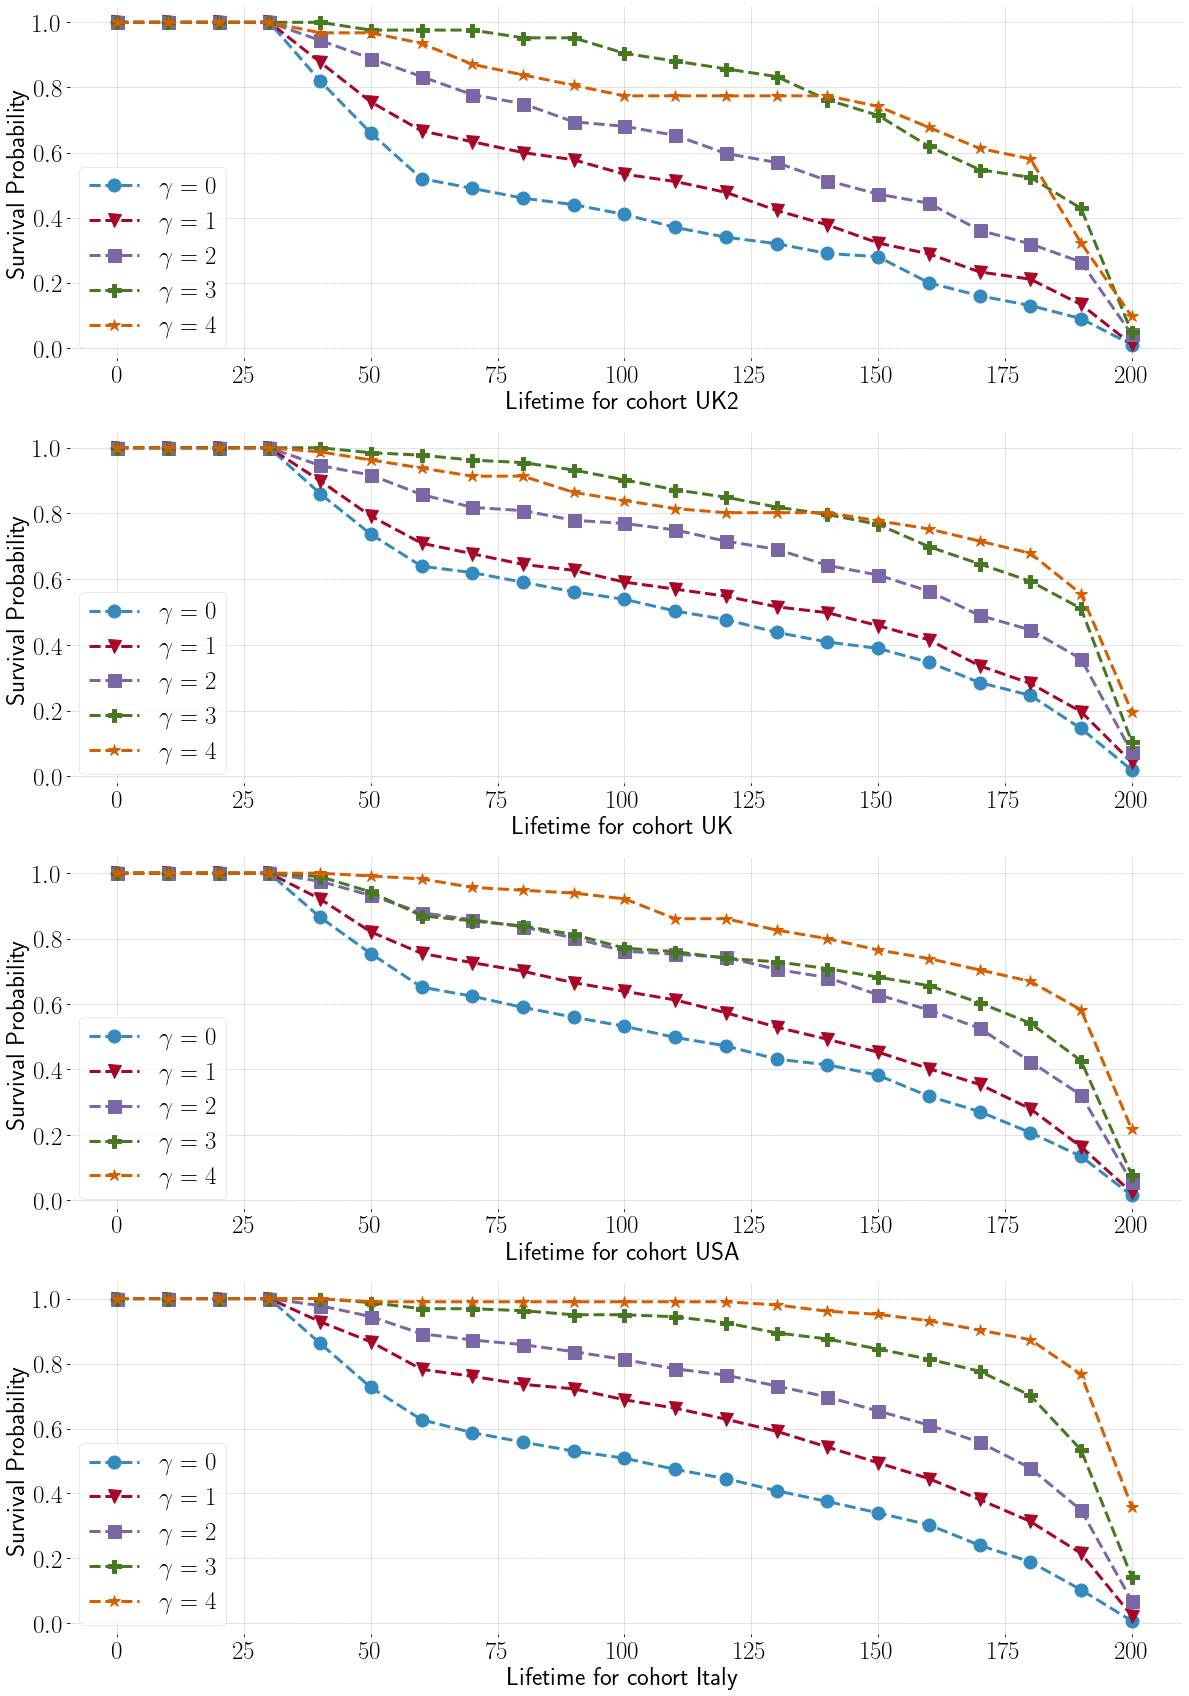

In [61]:
plt.figure(figsize=(20, 30))
p = 1
for c in survc.keys():
    plt.subplot(4, 1, p)
    plt.xlabel(f"Lifetime for cohort {cohorts[p - 1]}")
    plt.ylabel("Survival Probability")
    df = survc[c]
    for gamma in range(5):
        plt.plot([10 * x for x in df[gamma].index], df[gamma][0], marker=markers[gamma], markersize=13, ls="--", lw=3, label=fr'$\gamma = {gamma}$')
    plt.legend()
    p += 1
#plt.savefig("../commpatterns/img/supp/survc.pdf", dpi=150)

In [62]:
# for c in survc.keys():
#     tmp = pd.DataFrame({'lc': list(survc[c][0].index)})
#     for s in range(5):
#         df = survc[c][s]
#         tmp[f'p{int(s)}'] = df[0]
#     tmp.to_csv(f'../commpatterns/PNAS_paper/SI/figs/s4_{c}.dat', header=False, index=False, sep="\t")

For all cohorts combined:

In [63]:
alldff2['all'] = {}
for c in ['uk', 'mit', 'it']:
    alldff2['all'].update(alldff2[c])
    
len(alldff2['all']) == len(alldff2['uk']) + len(alldff2['mit']) + len(alldff2['it'])

True

In [64]:
survall = pc.get_survival(alldff2['all'])

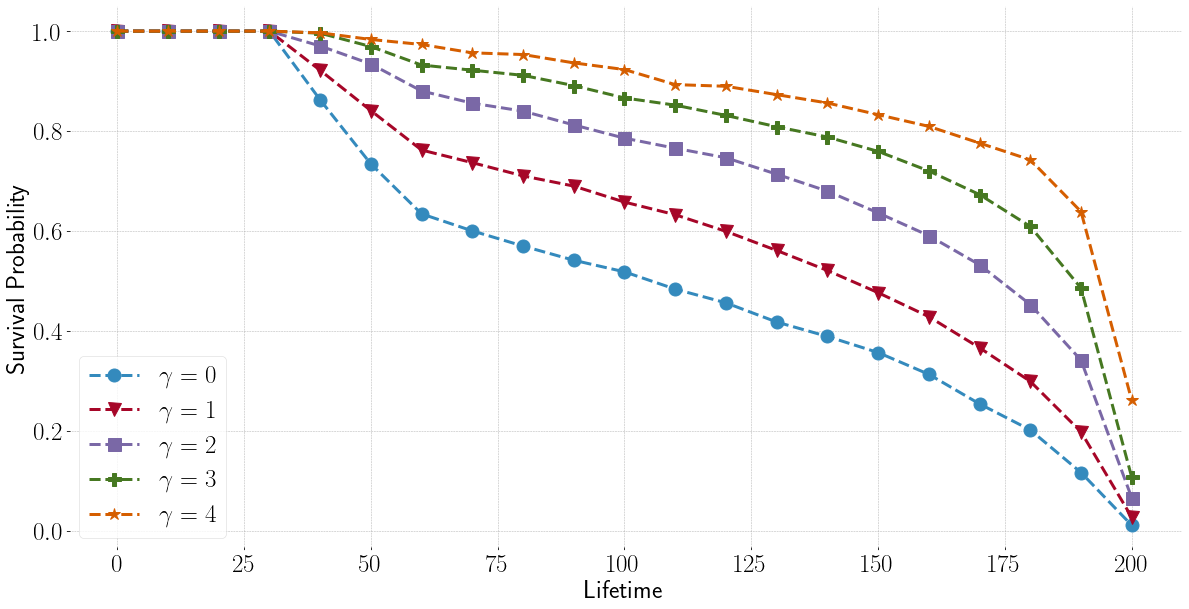

In [65]:
plt.xlabel(f"Lifetime ")
plt.ylabel("Survival Probability")
df = survall
for gamma in range(5):
    plt.plot([10 * x for x in df[gamma].index], df[gamma][0], marker=markers[gamma], markersize=13, ls="--", lw=3, label=fr'$\gamma = {gamma}$')
plt.legend()

In [66]:
# tmp = pd.DataFrame({'lc': list(survall[0].index)})
# for s in range(5):
#     df = survall[s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/SI/figs/s4_{c}.dat', header=False, index=False, sep="\t")

Contours and Survival points for figure 4

In [67]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(alldff2[c])

In [68]:
surv_cont = pc.get_survival(dffUM)

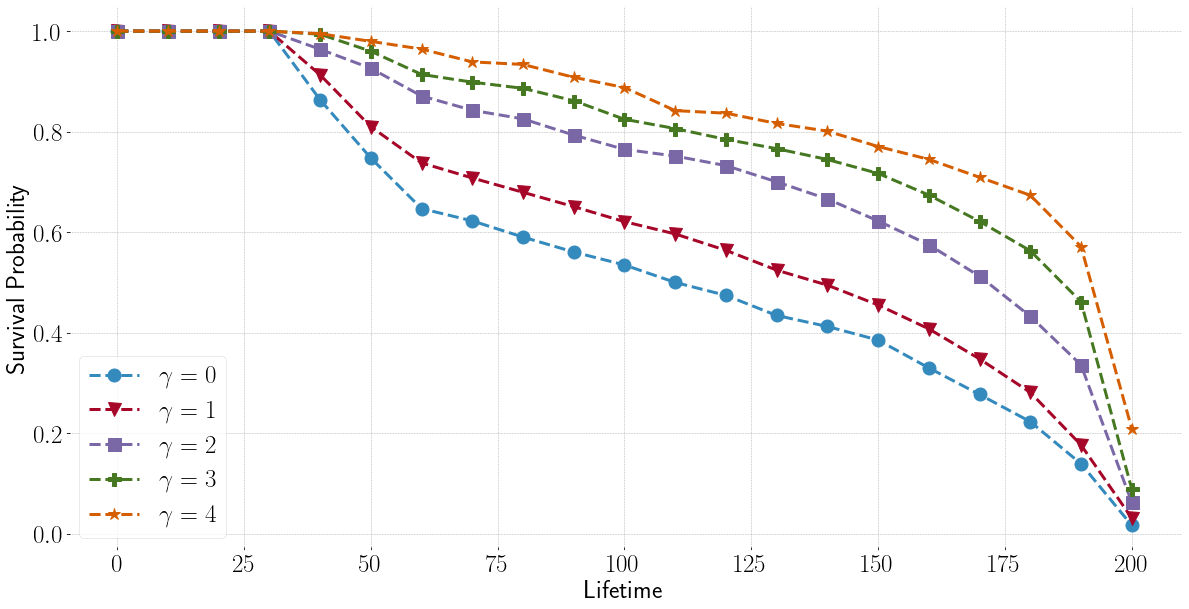

In [69]:
plt.xlabel(f"Lifetime ")
plt.ylabel("Survival Probability")
df = surv_cont
for gamma in range(5):
    plt.plot([10 * x for x in df[gamma].index], df[gamma][0], marker=markers[gamma], markersize=13, ls="--", lw=3, label=fr'$\gamma = {gamma}$')
plt.legend()

In [70]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/data/contour.dat", header=False, index=False, sep="\t")

In [71]:
points_it = pc.get_survival(alldff2['it'], unbinned=True)

In [72]:
points_it.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 55, 56, 62, 73, 74, 75, 81, 82, 100, 101, 121, 157])

In [73]:
tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
for s in sub:
    df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
    df.drop(columns='z', inplace=True)
    df.to_csv(f'../commpatterns/data/points{p}.dat', header=False, index=False, sep="\t")
    print(s)
    p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


/opt/homebrew/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/homebrew/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/homebrew/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/homebrew/lib/python3.9/sit

In [74]:
tmp

x    y         z
0     1    0  1.000000
1     1   10  1.000000
2     1   20  1.000000
3     1   30  1.000000
4     1   40  0.862172
..   ..  ...       ...
685  33  160  0.800000
686  33  170  0.800000
687  33  180  0.800000
688  33  190  0.800000
689  33  200  0.600000

[690 rows x 3 columns]

# Interevent times for each cohort

Consider this needs to be updated after the new filters (i.e. including the first 30 days of phone calls). Just to document the way I will compute the interevent times:

1. For each ego-alter pair, obtain the time (in days) between each phone call. Generate a list with the interevent times.
2. For each ego, average the coefficients of variation and put them into a cohort list
3. For each cohort, I should have a list of size equal to the number of egos, with all of the average coefficients of variation. Once again, if I take the average I will get the coefficient of variation for the cohort.

I can try a slight variation of this by not doing step 2 and get an average for all ego-alter pairs in the cohort. I can try to identify differences in both methods.

In [75]:
# ie = {}
# df = calls
# for ego in df['ego'].unique():
#     df1 = df.loc[df['ego'] == ego]
#     elllist = df1.groupby('alter')[['aclock']].max()
#     for alter in df1['alter'].unique():
#         lamb = elllist['aclock'][alter] // 67
#         df2 = df1.loc[df1['alter'] == alter]
#         ie[lamb] = ie.get(lamb, [])
#         ielist = list(df2['aclock'].diff())[1:]
#         if len(ielist) > 2:
#             cvar = np.nanstd(ielist) / np.nanmean(ielist)
#             if not pd.isna(cvar):
#                 ie[lamb].append(cvar)

In [76]:
def get_ietimes(callsdf, Deltaell = 67):
    df = callsdf
    iebyego = {}
    ieegoalter = {}
    ieegoalter['all'] = []
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        elllist = df1.groupby('alter')[['aclock']].max()
        iebyego[ego] = {}
        iebyego[ego]['all'] = []
        for alter in df1['alter'].unique():
            lamb = elllist['aclock'][alter] // Deltaell
            df2 = df1.loc[df1['alter'] == alter]
            df2 = df2.sort_values(by='aclock')
            ielist = list(df2['aclock'].diff())[1:]
            ieegoalter[lamb] = ieegoalter.get(lamb, [])
            if (len(ielist) > 2) and (np.nanmean(ielist) != 0):
                cvar = np.nanstd(ielist) / np.nanmean(ielist)
                if not pd.isna(cvar):
                    ieegoalter[lamb].append(cvar)
                    ieegoalter['all'].append(cvar)
                    iebyego[ego][lamb] = iebyego[ego].get(lamb, [])
                    iebyego[ego][lamb].append(cvar)
                    iebyego[ego]['all'].append(cvar)
    result = {}
    result['byego'] = iebyego
    result['egoalter'] = {}
    for lamb in ieegoalter.keys():
        result['egoalter'][lamb] = ieegoalter[lamb]
    return result

In [77]:
# def get_ietimes(callsdf, Deltaell = 67):
#     df = callsdf
#     iebyego = {}
#     ieegoalter = {}
#     ieegoalter['all'] = []
#     for ego in df['ego'].unique():
#         df1 = df.loc[df['ego'] == ego]
#         elllist = df1.groupby('alter')[['aclock']].max()
#         iebyego[ego] = {}
#         iebyego[ego]['all'] = []
#         for alter in df1['alter'].unique():
#             lamb = elllist['aclock'][alter] // Deltaell
#             df2 = df1.loc[df1['alter'] == alter]
#             df2 = df2.sort_values(by='aclock')
#             ielist = list(df2['aclock'].diff())[1:]
#             ieegoalter[lamb] = ieegoalter.get(lamb, [])
#             if len(ielist) > 2:
#                 cvar = np.nanstd(ielist) / np.nanmean(ielist)
#                 if not pd.isna(cvar):
#                     ieegoalter[lamb].append(cvar)
#                     ieegoalter['all'].append(cvar)
#                     iebyego[ego][lamb] = iebyego[ego].get(lamb, [])
#                     iebyego[ego][lamb].append(cvar)
#                     iebyego[ego]['all'].append(cvar)
#     result = {}
#     result['byego'] = iebyego
#     result['egoalter'] = {}
#     for lamb in ieegoalter.keys():
#         result['egoalter'][lamb] = ieegoalter[lamb]
#     return result

In [78]:
iedata = {}
for c in calls.keys():
    iedata[c] = get_ietimes(calls[c])

In [79]:
# with open('../itdata/ie_mtl1.pickle', 'rb') as handle:
#     iedata['it1'] = pickle.load(handle)
#     handle.close()
    
# with open('../itdata/ie_mtl2.pickle', 'rb') as handle:
#     iedata['it2'] = pickle.load(handle)
#     handle.close()
    
with open('../itdata/ie_mtl_all.pickle', 'rb') as handle:
    iedata['it'] = pickle.load(handle)
    handle.close()

In [80]:
iedata.keys()

dict_keys(['uk2', 'uk', 'mit', 'it'])

In [81]:
for c in iedata.keys():
    thelist = iedata[c]['egoalter']['all']
    print(c, np.mean(thelist), np.std(thelist))

uk2 1.7096331190163614 0.938364647390982
uk 1.6552591166051391 0.8103954731111254
mit 1.707914747186274 0.8087136445831905
it 1.2131625276600757 0.4890547603388951


In [82]:
for c in iedata.keys():
    thelist = []
    data = iedata[c]['byego']
    for ego in data.keys():
        acv = np.mean(data[ego]['all'])
        thelist.append(acv)
    print(len(thelist))
    print(c, np.nanmean(thelist), np.nanstd(thelist))

30
uk2 1.6313943401895739 0.29606681422918735
30
uk 1.6045368481256115 0.2347323410931652
130
mit 1.7311516005355927 0.29862876157010465
142
it 1.2176242572915152 0.13874803439665706


/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [83]:
ieH = {}
for c in iedata.keys():
    ieH[c] = {}
    ieH[c]['byego'] = {}
    data = iedata[c]['byego']
    for ego in data.keys():
        data2 = data[ego]
        for k in data2.keys():
            ieH[c]['byego'][k] = ieH[c]['byego'].get(k, [])
            ieH[c]['byego'][k].append(np.nanmean(data2[k]))
    ieH[c]['egoalter'] = {}
    for k in [0, 1, 2, 'all']:
        dat = [x for x in ieH[c]['byego'][k] if not pd.isna(x)]
        ieH[c]['byego'][k] = dat
        ieH[c]['egoalter'][k] = iedata[c]['egoalter'][k]
ieH['all'] = {}
for t in ['byego', 'egoalter']:
    ieH['all'][t] = {}
    for k in [0, 1, 2, 'all']:
        for c in ['uk', 'mit', 'it']:
            ieH['all'][t][k] = ieH['all'][t].get(k, [])
            ieH['all'][t][k] += ieH[c][t][k]
            
for c in ieH.keys():
    for t in ieH[c].keys():
        for k in ieH[c][t].keys():
            ieH[c][t][k] = (np.nanmean(ieH[c][t][k]), pc.histogram(ieH[c][t][k], 30, log=False), len(ieH[c][t][k]))

<ipython-input-83-4d5bdd7ac64a>:10: RuntimeWarning: Mean of empty slice
  ieH[c]['byego'][k].append(np.nanmean(data2[k]))


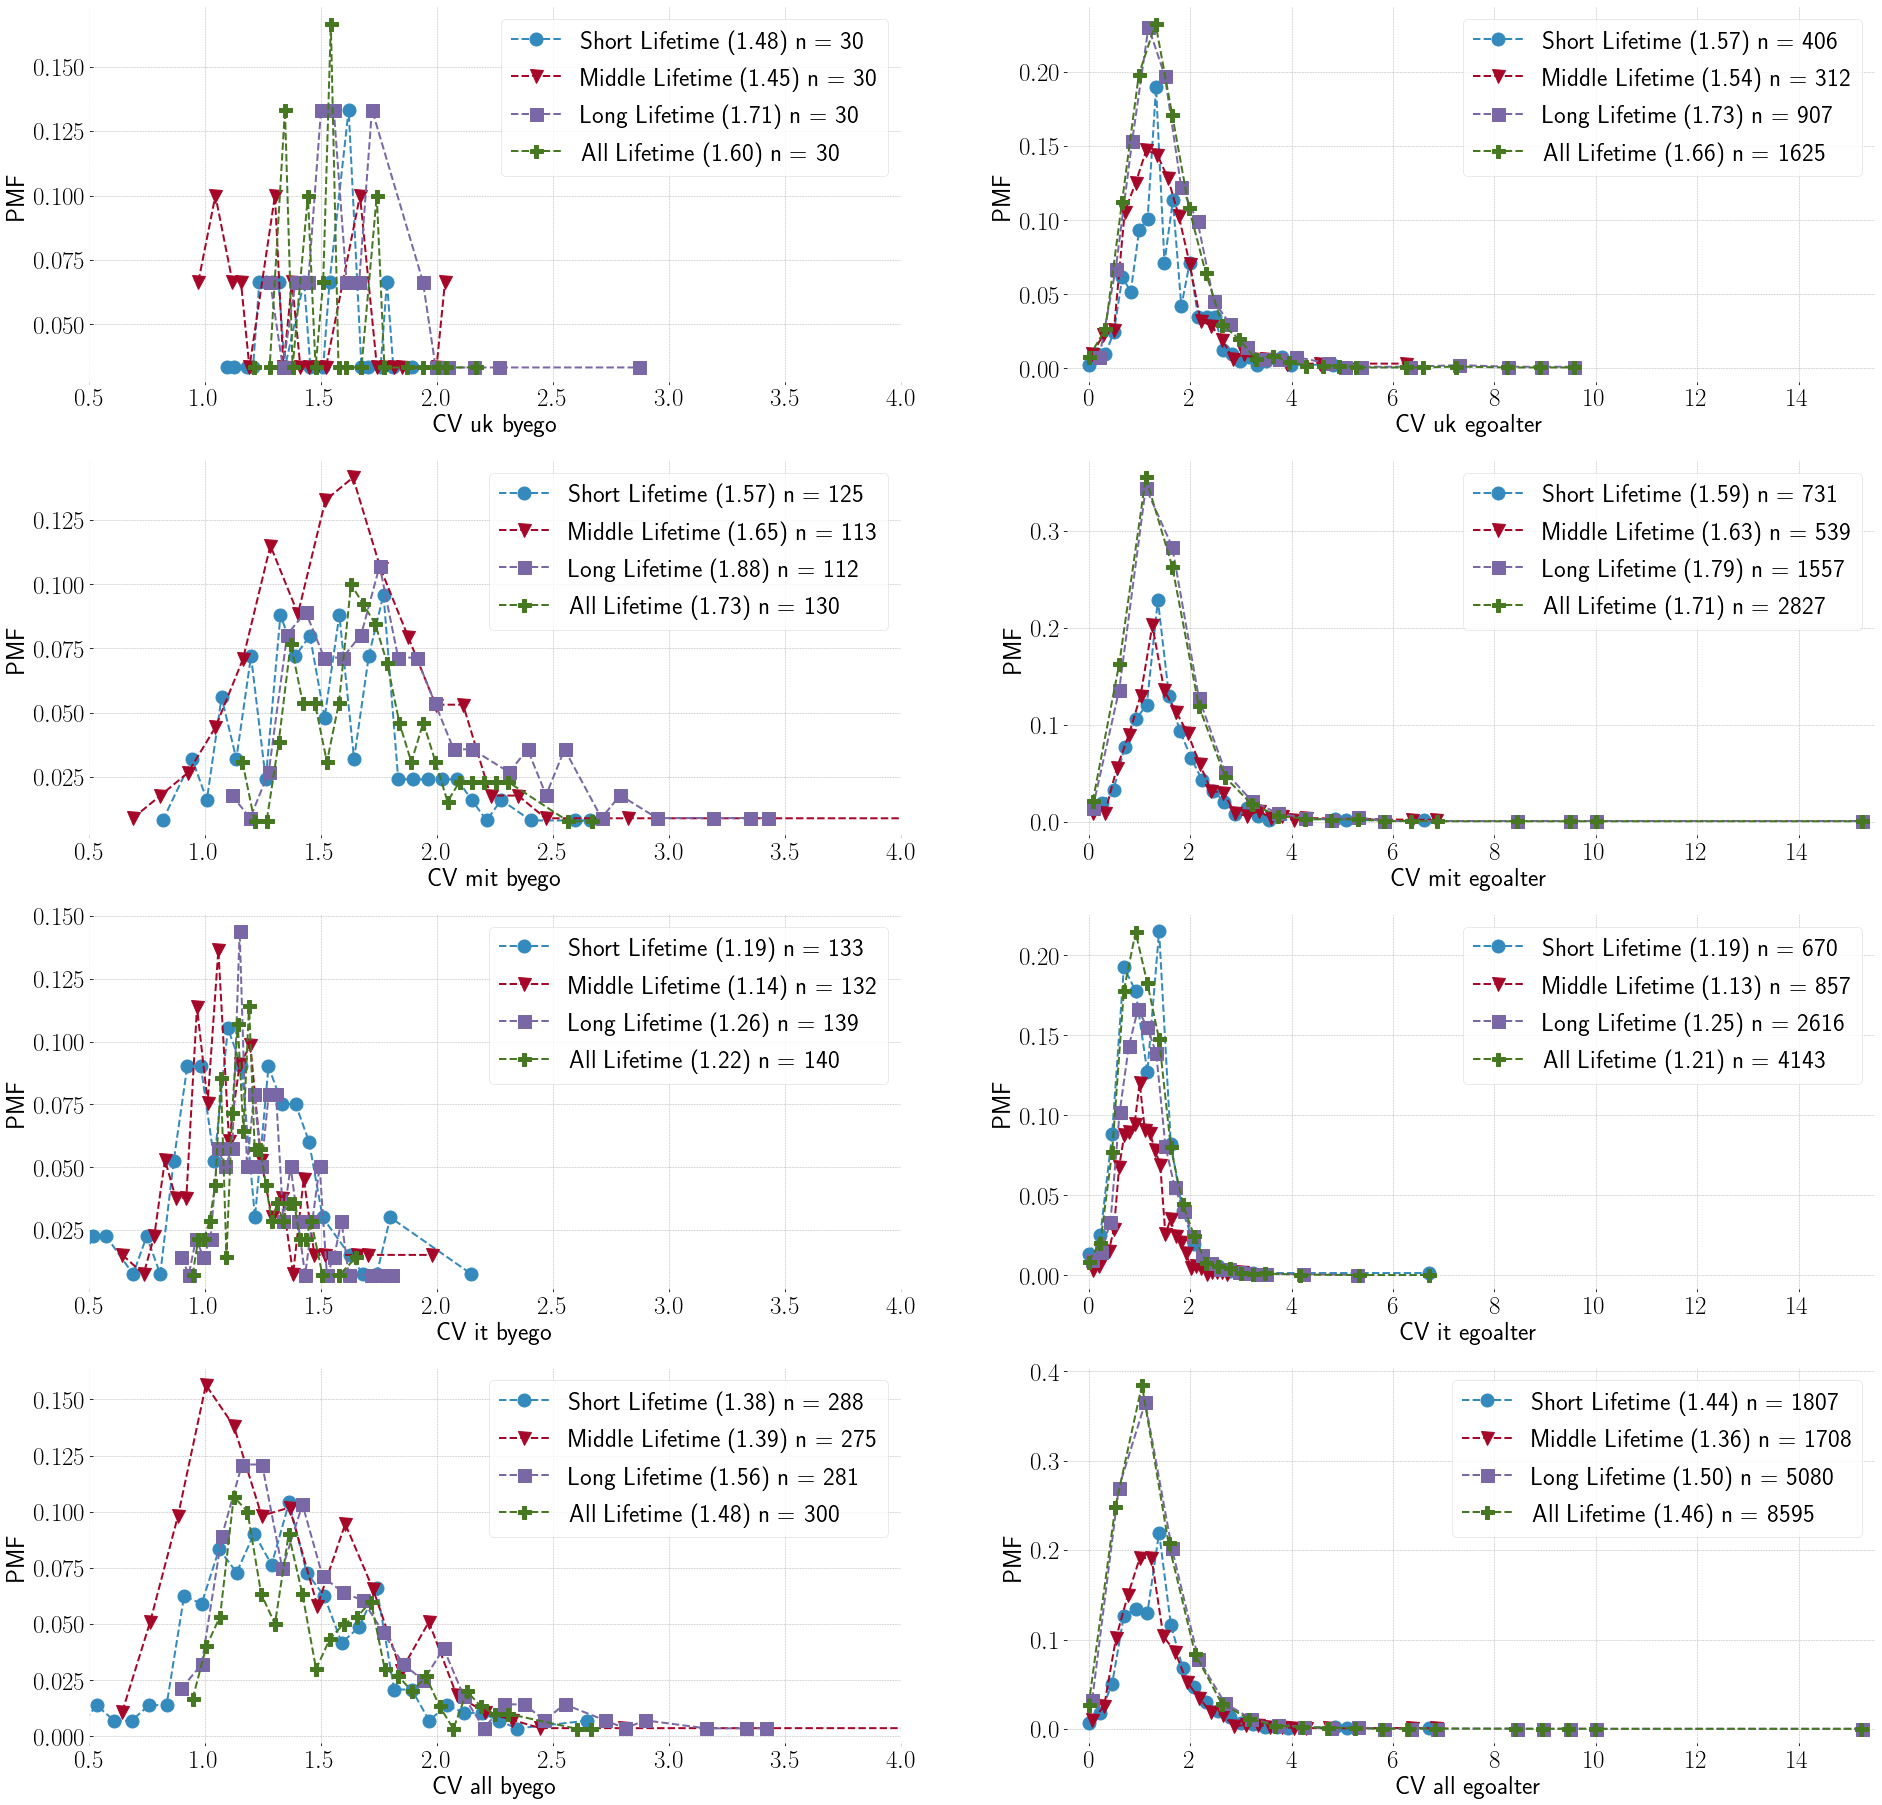

In [84]:
plt.figure(figsize=(32, 32))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime', 'All Lifetime']
p = 1
for c in ['uk', 'mit', 'it', 'all']:
    for t in ['byego', 'egoalter']:
        plt.subplot(4,2,p)
        if t == 'egoalter':
            plt.xlim(-0.5, 15.5)
        else:
            plt.xlim(0.5, 4)
        plt.xlabel(f"CV {c} {t}")
        plt.ylabel("PMF")
        lab = 0
        for k in [0, 1, 2, 'all']:
            plt.plot(ieH[c][t][k][1]['label'], ieH[c][t][k][1]['pmf'], marker=markers[lab], markersize=13, ls="--", label=f'{labels[lab]} ({ieH[c][t][k][0]:.2f}) n = {ieH[c][t][k][2]}')
            lab += 1
        plt.legend()
        p += 1

# Mutual Information

Needs to be recalculated with the updates in the data

In [85]:
alldff2.keys()

dict_keys(['uk2', 'uk', 'mit', 'it', 'all'])

In [86]:
calls.keys()

dict_keys(['uk2', 'uk', 'mit'])

In [87]:
lives = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])

with open('../itdata/mtl_all_lives.pickle', 'rb') as handle:
    tmp = pickle.load(handle)
    lives['it'] = tmp['all']
    handle.close()

lives['all'] = {}
for c in lives.keys():
    lives['all'].update(lives[c])

In [88]:
lives.keys()

dict_keys(['uk2', 'uk', 'mit', 'it', 'all'])

In [89]:
def get_month2(dff, lives):
    result = pd.DataFrame()
    idx = 0
    for ego in dff.keys():
        for alter in dff[ego].keys():
            df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
            if (len(df) > 0) and (ego in lives.keys()):
                result.at[idx, 'ego'] = ego
                result.at[idx, 'alter'] = alter
                result.at[idx, 'F'] = sum(df['f'])
                result.at[idx, 'lambda'] = lives[ego][alter]['ell']
                idx += 1
    return result

miall = []
for i in lives.keys():
    miall.append(get_month2(alldff2[i], lives[i]))

In [90]:
import sklearn.metrics as sk
miplot = []
for i in miall:
    miplot.append(sk.mutual_info_score(i['F'], i['lambda']))
for i in range(len(miplot)):
    print(list(lives.keys())[i],"\t", miplot[i],"\t", miplot[i]*1.44)

uk2 	 1.675093445804767 	 2.4121345619588643
uk 	 1.004193751378601 	 1.4460390019851854
mit 	 0.874544800838374 	 1.2593445132072585
it 	 0.4492692020932061 	 0.6469476510142167
all 	 0.4347075509066797 	 0.6259788733056187


In [91]:
for c in ['uk', 'mit', 'it']:
    p = 0
    for ego in alldff2[c].keys():
        p += len(alldff[c][ego].keys())
    print(c, p)

uk 4943
mit 7840
it 16984


# Additional checks

In [92]:
def get_avgfa(fresult, lives, ell0, ellf):
    fi = {}
    for ego in fresult.keys():
        nalt = 0
        fi[ego] = {}
        for alter in fresult[ego].keys():
            ell = lives[ego][alter]['ell']
            if (ell >= ell0) and (ell <= ellf):
                df = fresult[ego][alter]
                nalt += 1
                for i in df.index:
                    a = df.at[i, 'alpha']
                    f = df.at[i, 'f']
                    fi[ego][a] = fi[ego].get(a, 0) + f
        for a in fi[ego].keys():
            fi[ego][a] /= nalt
    
    tmp = {}
    for ego in fi.keys():
        for a in fi[ego].keys():
            tmp[a] = tmp.get(a, [])
            tmp[a].append(fi[ego][a])
    for a in tmp.keys():
        tmp[a] = np.mean(tmp[a])
        
    res = pd.DataFrame.from_dict(tmp, orient='index')
    res = res.sort_index()
    return res

In [99]:
get_avgfa(alldff['uk'], lives['uk'], 50, 59)

0
0  3.348571
1  3.192063
2  3.773810
3  2.696667

In [104]:
og = copy.deepcopy(supC['mit'][51][1])

In [106]:
mit = callT['mit'][200]
tmpdff = pc.get_f(mit, 'all', 15, 51)

In [107]:
test1 = get_avgfa(tmpdff, lives['mit'], 51, 101)

In [110]:
test2 = get_avgfa(tmpdff, lives['mit'], 50, 80)

In [134]:
test3 = get_avgfa(tmpdff, lives['mit'], 60, 80)

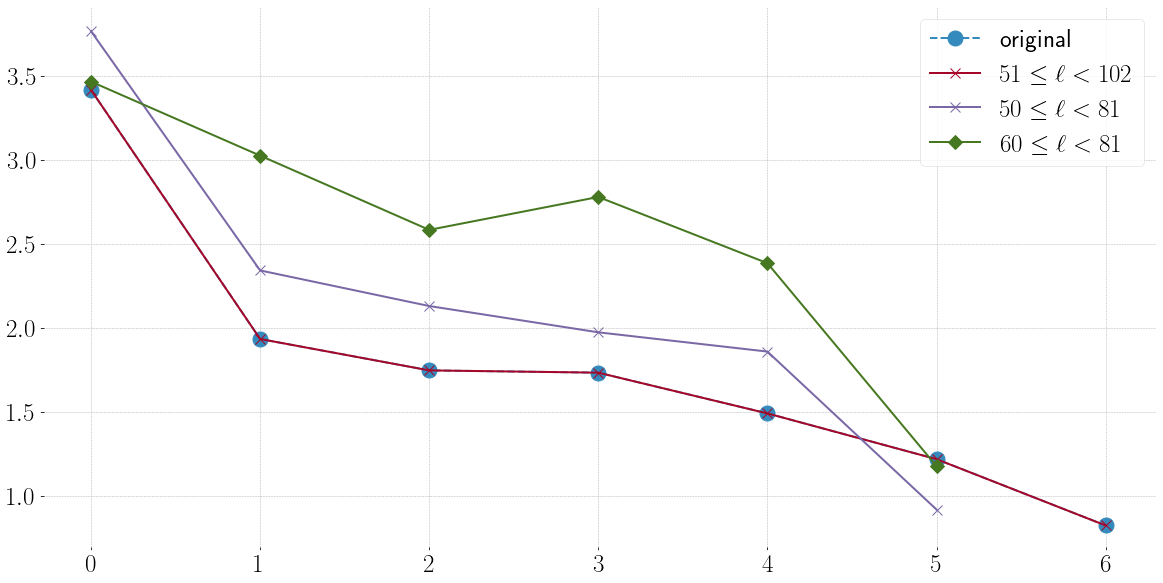

In [137]:
plt.plot(og.index, og['alpha'], marker="o", markersize=15, ls="--", lw=2, label='original')
plt.plot(test1.index, test1[0], marker="x", markersize=10, ls="-", lw=2, label=r'$51 \leq \ell < 102$')
plt.plot(test2.index, test2[0], marker="x", markersize=10, ls="-", lw=2, label=r'$50 \leq \ell < 81$')
plt.plot(test3.index, test3[0], marker="D", markersize=10, ls="-", lw=2, label=r'$60 \leq \ell < 81$')
plt.legend()

In [125]:
lives['it'].keys()

dict_keys(['all'])

In [112]:
def get_avgfa2(fresult, lives, ell0, ellf):
    fi = {}
    for ego in fresult.keys():
        nalt = {}
        fi[ego] = {}
        for alter in fresult[ego].keys():
            ell = lives[ego][alter]['ell']
            if (ell >= ell0) and (ell <= ellf):
                df = fresult[ego][alter]
                for i in df.index:
                    a = df.at[i, 'alpha']
                    f = df.at[i, 'f']
                    nalt[a] = nalt.get(a, 0) + 1
                    fi[ego][a] = fi[ego].get(a, 0) + f
        for a in fi[ego].keys():
            fi[ego][a] /= nalt[a]
    
    tmp = {}
    for ego in fi.keys():
        for a in fi[ego].keys():
            tmp[a] = tmp.get(a, [])
            tmp[a].append(fi[ego][a])
    for a in tmp.keys():
        tmp[a] = np.mean(tmp[a])
        
    res = pd.DataFrame.from_dict(tmp, orient='index')
    res = res.sort_index()
    return res

In [113]:
test1b = get_avgfa2(tmpdff, lives['mit'], 51, 101)

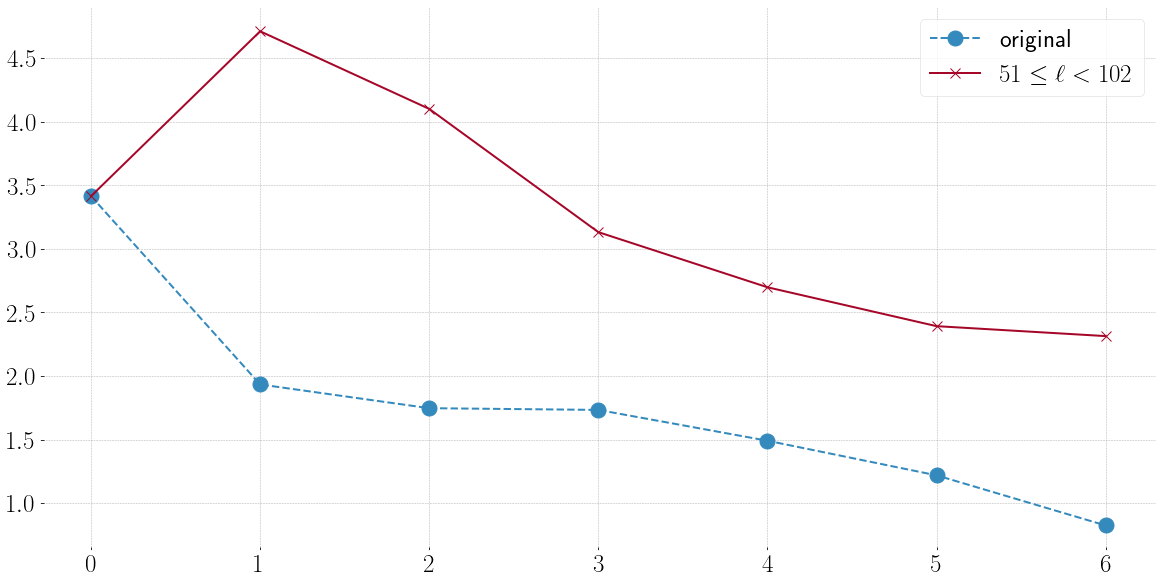

In [115]:
plt.plot(og.index, og['alpha'], marker="o", markersize=15, ls="--", lw=2, label='original')
plt.plot(test1b.index, test1b[0], marker="x", markersize=10, ls="-", lw=2, label=r'$51 \leq \ell < 102$')
plt.legend()

In [116]:
calls = {}
for c in ['uk2', 'uk', 'mit']:    
    df = unfiltered[c].loc[unfiltered[c]['aclock'] <= 200]
#     if c != 'uk2':
#         une = df.groupby('ego')[['uclock']].min()
#         deux = pd.DataFrame()
#         for ego in df['ego'].unique():
#             tmp = df.loc[df['ego'] == ego]
#             minday = une.loc[ego]['uclock'] + 10
#             df1 = df.loc[df['uclock'] >= minday]
#             deux = deux.append(df1).reset_index(drop=True)
#         df = deux
    uno = pd.DataFrame()
    T = max(df['uclock'])
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df3 = df2.copy()
                df3['aclock'] = df2['uclock'] - mint
                uno = uno.append(df3).reset_index(drop=True)
    calls[c] = uno
    print(f"done with {c}")

done with uk2
done with uk
done with mit


In [117]:
alldff = {}
for c in calls.keys():
    alldff[c] = pc.get_f(calls[c], 'all', 15, 67)
    
with open('../itdata/mtl_all_lambda_alpha_fig2.pickle', 'rb') as handle:
    alldff['it'] = pickle.load(handle)
    handle.close()

In [121]:
for c in ['uk2', 'uk', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])

In [120]:
stablec = {}
for c in alldff.keys():
    b = pc.get_b(alldff[c], 'alpha')
    stablec[c] = pc.plot_g(b, 'alpha')

In [132]:
stablec2 = {}
for c in alldff.keys():
    l = 0
    stablec2[c] = {}
    for ells in [(0,66), (67,134), (135,200)]:
        stablec2[c][l] = get_avgfa2(alldff[c], lives[c], ells[0], ells[1])
        l += 1

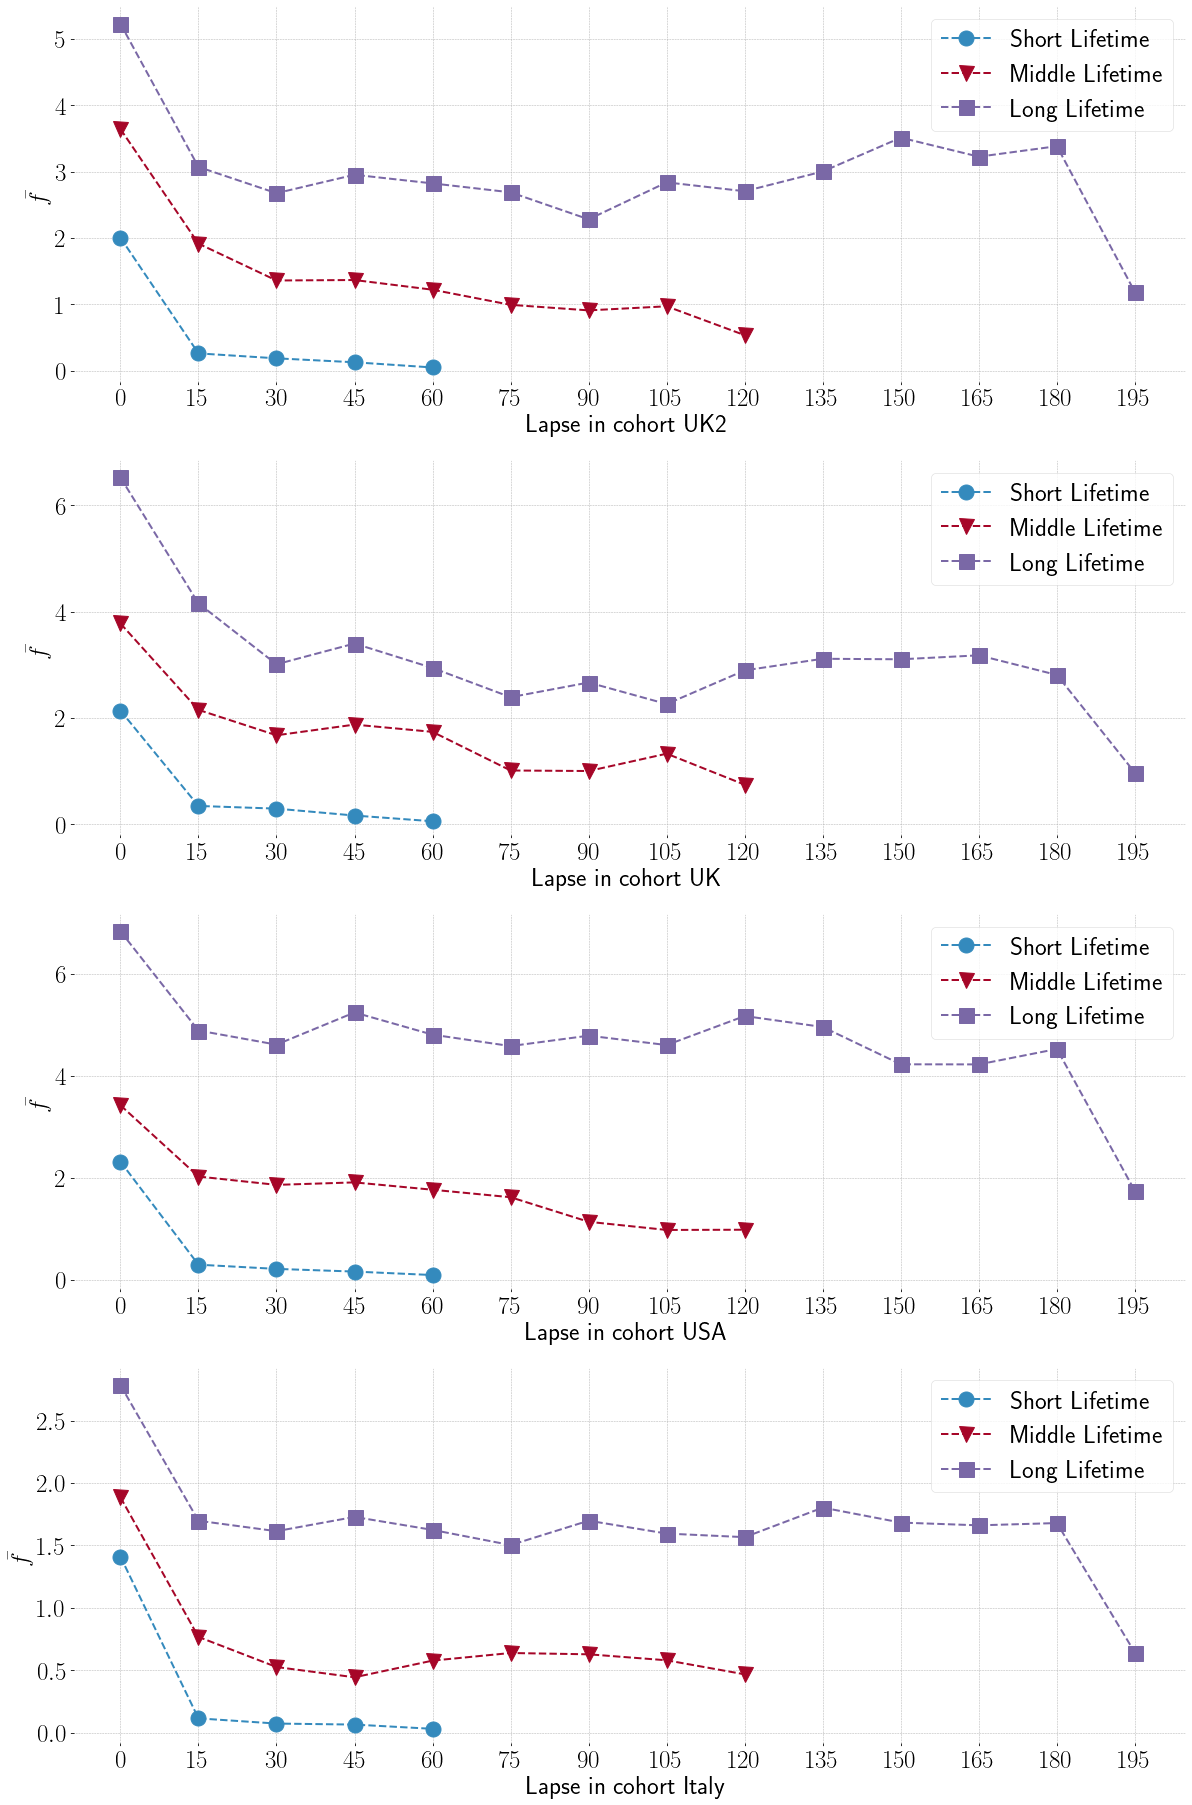

In [130]:
plt.figure(figsize=(20, 32))
p = 1
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
cohorts = ['UK2', 'UK', 'USA', 'Italy']
for c in ['uk', 'uk2', 'mit', 'it']:
    plt.subplot(4,1,p)
    plt.xlabel(f"Lapse in cohort {cohorts[p - 1]}")
    plt.ylabel(r"$\bar{f}$")
    plt.xticks(range(0, 201, 15))
    for lamb in stablec[c].keys():
        l = int(lamb)
        plt.plot([15 * x for x in stablec[c][l].index], stablec[c][l]['alpha'], marker=markers[l], ls="--", markersize=15, label=labels[l])
    plt.legend()
    p += 1

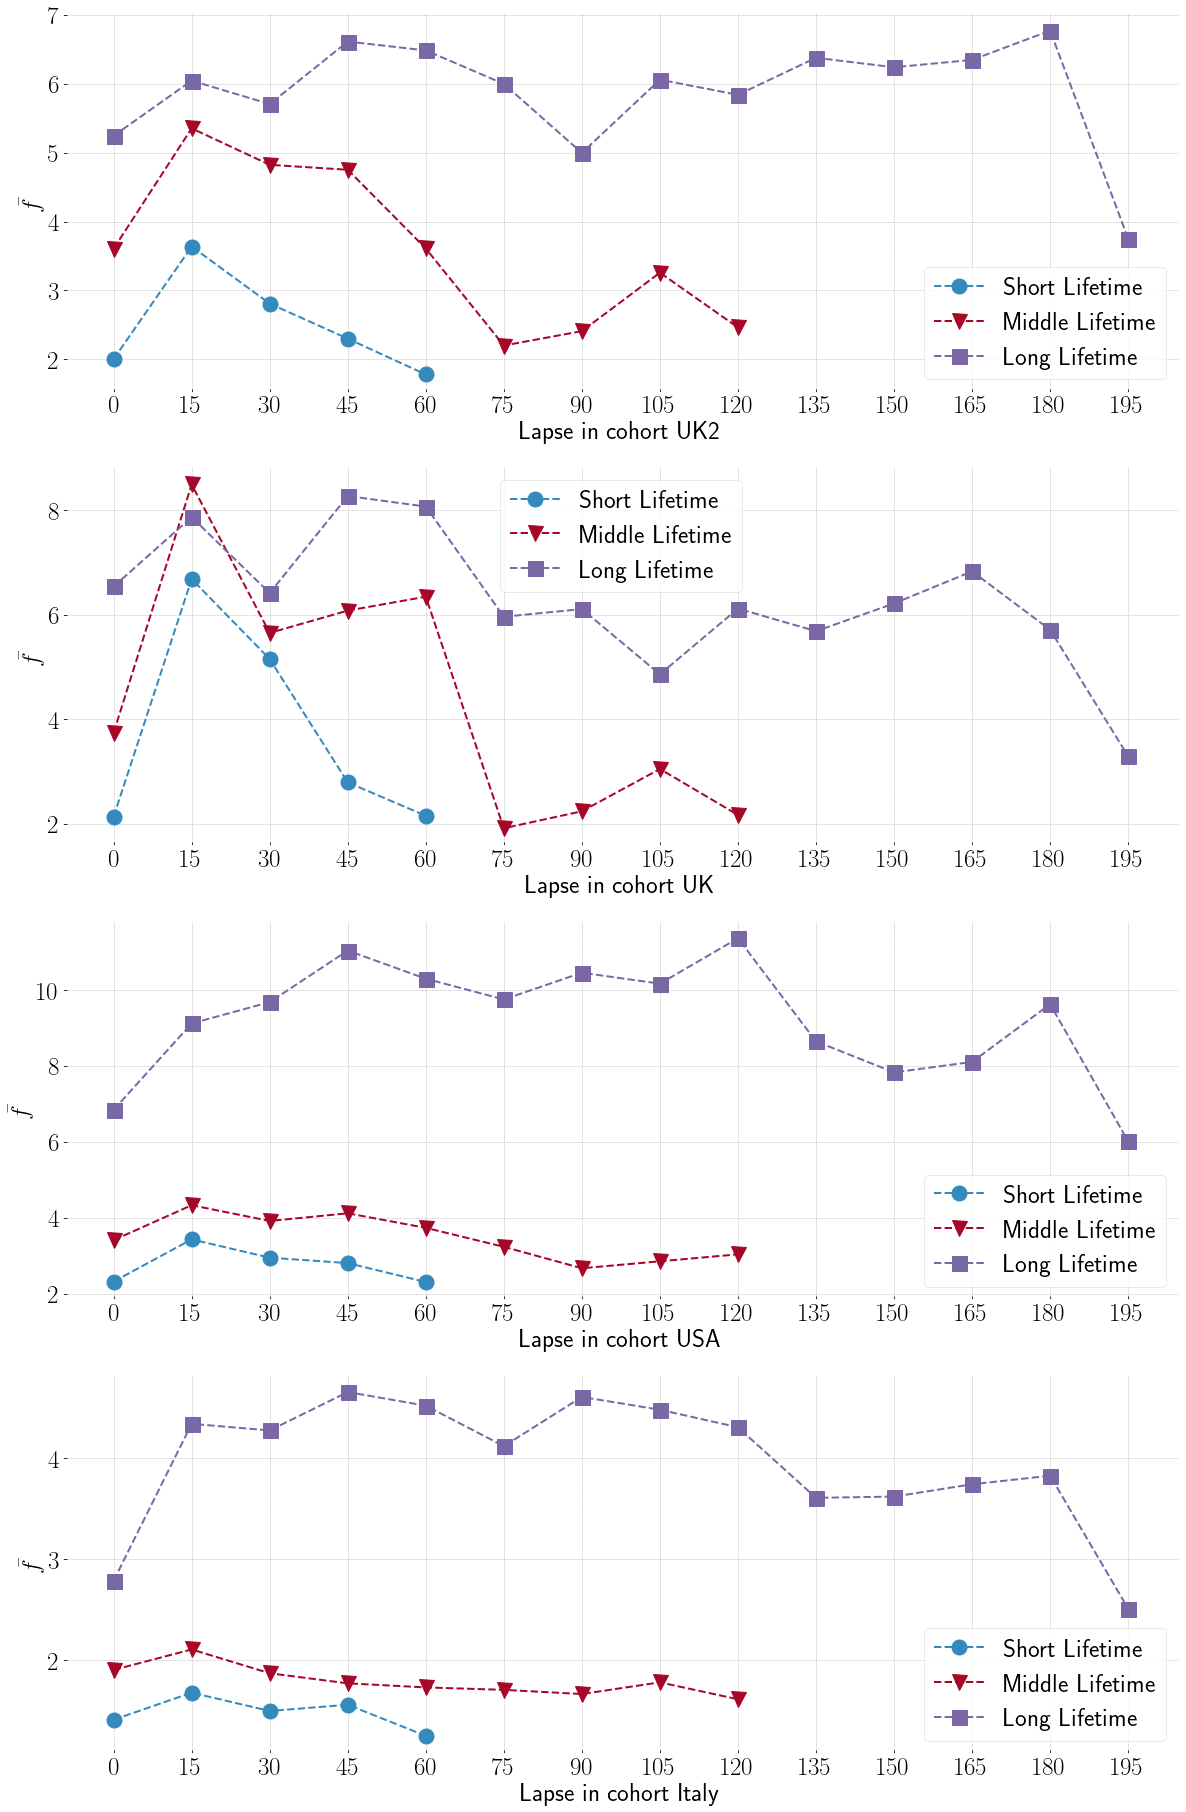

In [133]:
plt.figure(figsize=(20, 32))
p = 1
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
cohorts = ['UK2', 'UK', 'USA', 'Italy']
for c in ['uk', 'uk2', 'mit', 'it']:
    plt.subplot(4,1,p)
    plt.xlabel(f"Lapse in cohort {cohorts[p - 1]}")
    plt.ylabel(r"$\bar{f}$")
    plt.xticks(range(0, 201, 15))
    for lamb in stablec2[c].keys():
        l = int(lamb)
        plt.plot([15 * x for x in stablec2[c][l].index], stablec2[c][l][0], marker=markers[l], ls="--", markersize=15, label=labels[l])
    plt.legend()
    p += 1